## Imports

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from scipy import stats

In [2]:
TABLE_PATH = './Ansatz_training_reports(CostaSH).csv'
KL_DIV_TABLE_PATH = '../circuits/CostaSH/klMeasures.csv'

## Get the data

In [19]:
performance_df = pd.read_csv(TABLE_PATH)
ansatz_df = pd.read_csv(KL_DIV_TABLE_PATH)

In [20]:
ansatz_df

,Qubits,name,Layers,num_params,KL divergence
0,1,hr,1,3,0.041942
1,1,ru,1,3,0.045850
2,1,ruu,1,6,0.034767
3,1,rx,1,1,0.249244
4,1,ry,1,1,0.233362
5,1,rz,1,1,4.317488
6,2,alpha,1,4,0.074536
7,2,beta,1,18,0.027473
8,2,gamma,1,4,0.483940
9,2,phi,1,4,0.085627


In [21]:
performance_df.duplicated().unique()

array([False])

In [22]:
merged_df = pd.merge(performance_df, ansatz_df, 
                    left_on='ARQUITETURA_ANSATZ', 
                    right_on='name', 
                    how='left')
merged_df.head()

,ARQUITETURA_ANSATZ,INPUT_EMBEDDING,DATASET,DATASET_DIVISION_INDEX,OPTIMIZER,UNSUPERVISED_METRIC,MEASURED_WIRES,MEASURE_TYPE,TRAIN_METRIC_COST,TEST_METRIC_COST,...,TEST_ACCURACY,WEIGHT,BIAS,USE_BIAS,Normalized,Qubits,name,Layers,num_params,KL divergence
0,ry,amplitude,xor_50samples_no_noise,0,SPSAOptimizer(10),silhouette,1,expval,0.619865,0.666456,...,-0.025316,[0.47918502],[0.1393557],YES,YES,1,ry,1,1,0.233362
1,ry,amplitude,xor_50samples_no_noise,0,SPSAOptimizer(10),calinski harabasz,1,expval,0.036708,0.100818,...,-0.025316,[0.5348127],[0.17666432],YES,YES,1,ry,1,1,0.233362
2,ry,amplitude,xor_50samples_no_noise,1,SPSAOptimizer(10),silhouette,1,expval,0.641732,0.621505,...,0.069620,[0.52452594],[0.14062875],YES,YES,1,ry,1,1,0.233362
3,ry,amplitude,xor_50samples_no_noise,1,SPSAOptimizer(10),calinski harabasz,1,expval,10.000000,10.000000,...,0.000000,[2.37333092],[1.9916107],YES,YES,1,ry,1,1,0.233362
4,ry,amplitude,xor_50samples_no_noise,2,SPSAOptimizer(10),silhouette,1,expval,0.644613,0.573947,...,0.352675,[0.53885579],[0.13416904],YES,YES,1,ry,1,1,0.233362


In [23]:
import re

# Sample data (replace with your actual DataFrame)
data = {
    'dataset': [
        'blobs_2classes_2features_500samples_no_noise',
        'blobs_3classes_4features_50samples_low_noise',
        'circles_50samples_low_noise',
        'moons_2classes_100samples_medium_noise',
        'custom_3classes_8features_200samples_high_noise'
    ]
}
df = pd.DataFrame(data)

def parse_dataset_name(name):
    #defaults
    num_classes = 2
    num_features = 2
    num_samples = -1
    noise_level = 'no_noise'
    
    dataset_type = name.split('_')[0]
    
    class_match = re.search(r'(\d+)classes', name)
    feature_match = re.search(r'(\d+)features', name)
    sample_match = re.search(r'(\d+)samples', name)
    noise_match = re.search(r'(no|low|medium|high)_noise', name)
    
    if class_match:   num_classes  = int(class_match.group(1))
    if feature_match: num_features = int(feature_match.group(1))
    if sample_match:  num_samples  = int(sample_match.group(1))
    if noise_match:   noise_level  = noise_match.group(1) + '_noise'
    
    return pd.Series({
        'dataset_type': dataset_type,
        'num_classes': num_classes,
        'num_features': num_features,
        'num_samples': num_samples,
        'noise_level': noise_level
    })


complete_df = pd.concat([
    merged_df, 
    merged_df['DATASET'].apply(parse_dataset_name)
], axis=1)

noise_order = ['no_noise', 'low_noise'] #, 'medium_noise', 'high_noise']
complete_df['noise_level'] = pd.Categorical(complete_df['noise_level'], categories=noise_order, ordered=True)

complete_df = complete_df.dropna()
complete_df = complete_df.drop(columns=['BIAS',  'WEIGHT'])
complete_df

,ARQUITETURA_ANSATZ,INPUT_EMBEDDING,DATASET,DATASET_DIVISION_INDEX,OPTIMIZER,UNSUPERVISED_METRIC,MEASURED_WIRES,MEASURE_TYPE,TRAIN_METRIC_COST,TEST_METRIC_COST,...,Qubits,name,Layers,num_params,KL divergence,dataset_type,num_classes,num_features,num_samples,noise_level
0,ry,amplitude,xor_50samples_no_noise,0,SPSAOptimizer(10),silhouette,1,expval,0.619865,0.666456,...,1,ry,1,1,0.233362,xor,2,2,50,no_noise
1,ry,amplitude,xor_50samples_no_noise,0,SPSAOptimizer(10),calinski harabasz,1,expval,0.036708,0.100818,...,1,ry,1,1,0.233362,xor,2,2,50,no_noise
2,ry,amplitude,xor_50samples_no_noise,1,SPSAOptimizer(10),silhouette,1,expval,0.641732,0.621505,...,1,ry,1,1,0.233362,xor,2,2,50,no_noise
3,ry,amplitude,xor_50samples_no_noise,1,SPSAOptimizer(10),calinski harabasz,1,expval,10.000000,10.000000,...,1,ry,1,1,0.233362,xor,2,2,50,no_noise
4,ry,amplitude,xor_50samples_no_noise,2,SPSAOptimizer(10),silhouette,1,expval,0.644613,0.573947,...,1,ry,1,1,0.233362,xor,2,2,50,no_noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42895,L,phasex,blobs_3classes_4features_500samples_low_noise,2,SPSAOptimizer(10),calinski harabasz,1,expval,0.668053,0.570421,...,4,L,1,12,0.239632,blobs,3,4,500,low_noise
42896,L,phasex,blobs_3classes_4features_500samples_low_noise,3,SPSAOptimizer(10),silhouette,1,expval,1.034327,1.056910,...,4,L,1,12,0.239632,blobs,3,4,500,low_noise
42897,L,phasex,blobs_3classes_4features_500samples_low_noise,3,SPSAOptimizer(10),calinski harabasz,1,expval,0.699408,4.230354,...,4,L,1,12,0.239632,blobs,3,4,500,low_noise
42898,L,phasex,blobs_3classes_4features_500samples_low_noise,4,SPSAOptimizer(10),silhouette,1,expval,1.108029,1.128998,...,4,L,1,12,0.239632,blobs,3,4,500,low_noise


In [24]:
ansatz_order = ansatz_df.sort_values(['KL divergence'])['name'].unique()
ansatz_order

ansatz_order_by_qubits = [[]]
for q in range(1, 5):
    this_order = ansatz_df[ ansatz_df['Qubits'] == q].sort_values(['KL divergence'])['name'].unique()
    ansatz_order_by_qubits.append(this_order)
    print(list(this_order))

    

['ruu', 'hr', 'ru', 'ry', 'rx', 'rz']
['beta', 'alpha', 'phi', 'theta', 'gamma']
['9_divwe', '5_tano', '8_nake', '4_wana', '2_yadi', '3_tatu', '7_sambwadi', '0_zero', '1_mochi', '6_samanu']
['M', 'O', 'G', 'D', 'I', 'K', 'N', 'J', 'C', 'L', 'A', 'H', 'B', 'E', 'F']


# sla

In [ ]:

corr_test,  p_test  = pearsonr(complete_df['KL divergence'], complete_df['TEST_ACCURACY'])
corr_train, p_train = pearsonr(complete_df['KL divergence'], complete_df['TRAIN_ACCURACY'])
print(f"Test  Accuracy vs KL Divergence - Correlation: {corr_test:.3f}, p-value: {p_test:.3f}")
print(f"Train Accuracy vs KL Divergence - Correlation: {corr_train:.3f}, p-value: {p_train:.3f}")


Test  Accuracy vs KL Divergence - Correlation: -0.010, p-value: 0.097
Train Accuracy vs KL Divergence - Correlation: -0.010, p-value: 0.093


Nos dados gerais, há baixa correlação entre a KL divergence e a acurácia.

In [154]:

analise_df = complete_df[ (complete_df['USE_BIAS'] == 'NO') & (complete_df['KL divergence'] < 1) ]
corr_test,  p_test  = pearsonr(analise_df['KL divergence'], analise_df['TEST_ACCURACY'])
corr_train, p_train = pearsonr(analise_df['KL divergence'], analise_df['TRAIN_ACCURACY'])
print(f"Test  Accuracy vs KL Divergence - Correlation: {corr_test:.3f}, p-value: {p_test}")
print(f"Train Accuracy vs KL Divergence - Correlation: {corr_train:.3f}, p-value: {p_train}")

Test  Accuracy vs KL Divergence - Correlation: -0.084, p-value: 2.1030358597542718e-22
Train Accuracy vs KL Divergence - Correlation: -0.094, p-value: 6.651921837142929e-28


In [389]:
less_df = (complete_df[complete_df['USE_BIAS'] == 'YES'])[['name', 'dataset_type', 'UNSUPERVISED_METRIC', 'num_classes', 'num_features', 'noise_level', 'TRAIN_ACCURACY', 'TEST_ACCURACY', 'KL divergence',]].copy()
less_df = less_df.groupby(['name', 'dataset_type', 'UNSUPERVISED_METRIC', 'num_classes', 'num_features', 'noise_level'], observed=True).mean().reset_index()

# If you want more statistics than just the mean
detailed_stats = (less_df.groupby(['name', 'dataset_type', 'UNSUPERVISED_METRIC','num_classes', 'num_features', 'noise_level'], observed=True)
                  .agg({'TRAIN_ACCURACY': ['mean', 'std', 'count'],
                       'TEST_ACCURACY': ['mean', 'std'],
                       'KL divergence': ['mean', 'min', 'max']})
                  .round(4)
                  .reset_index())

# # less_df
# detailed_stats

In [ ]:
from scipy.stats import f_oneway
numeric_cols = ['TRAIN_METRIC_COST', 'TEST_METRIC_COST', 
                'TRAIN_ACCURACY', 'TEST_ACCURACY',]

def anova_test(df, categorical_col, numeric_col):
    groups = [group[numeric_col].dropna() for name, group in df.groupby(categorical_col)]
    f_val, p_val = f_oneway(*groups)
    return f_val, p_val

# Example usage:
for col in ['INPUT_EMBEDDING', 'UNSUPERVISED_METRIC', 'dataset_type']:
    for num in numeric_cols:
        f_val, p_val = anova_test(complete_df, col, num)
        print(f"{col} vs {num} { ' ' * (40 - len(col) - len(num))  } p-value: {p_val:.8f} | f_val: {f_val:.6f} ")

INPUT_EMBEDDING vs TRAIN_METRIC_COST          p-value: 0.00067741 | f_val: 11.552799 
INPUT_EMBEDDING vs TEST_METRIC_COST           p-value: 0.00000000 | f_val: 100.799632 
INPUT_EMBEDDING vs TRAIN_ACCURACY             p-value: 0.00000000 | f_val: 13049.606157 
INPUT_EMBEDDING vs TEST_ACCURACY              p-value: 0.00000000 | f_val: 10958.342241 
UNSUPERVISED_METRIC vs TRAIN_METRIC_COST      p-value: 0.00000000 | f_val: 37.168133 
UNSUPERVISED_METRIC vs TEST_METRIC_COST       p-value: 0.00000000 | f_val: 186.169503 
UNSUPERVISED_METRIC vs TRAIN_ACCURACY         p-value: 0.00000000 | f_val: 39.410959 
UNSUPERVISED_METRIC vs TEST_ACCURACY          p-value: 0.00003168 | f_val: 17.319790 
dataset_type vs TRAIN_METRIC_COST             p-value: 0.00000886 | f_val: 8.721601 
dataset_type vs TEST_METRIC_COST              p-value: 0.00098949 | f_val: 5.431010 
dataset_type vs TRAIN_ACCURACY                p-value: 0.00000000 | f_val: 741.995168 
dataset_type vs TEST_ACCURACY                 p

In [ ]:
numeric_cols = ['TRAIN_METRIC_COST', 'TEST_METRIC_COST', 
                'TRAIN_ACCURACY', 'TEST_ACCURACY',
                'Qubits', 'num_params', 'KL divergence',
                'num_classes', 'num_features', 'num_samples']

In [25]:
all_arquiteturas = ansatz_df['name'].unique()

symbol_map = {'alpha':'α', 'beta':'β', 'gamma':'γ', 'phi':'φ', 'theta':'θ'}
short_arq = [name.split('_')[0] if '0' <= name[0] <= '9' else name for name in all_arquiteturas]
short_arq = [symbol_map[name] if name in symbol_map else name for name in short_arq]
all_arquiteturas, short_arq

(array(['hr', 'ru', 'ruu', 'rx', 'ry', 'rz', 'alpha', 'beta', 'gamma',
        'phi', 'theta', '0_zero', '1_mochi', '2_yadi', '3_tatu', '4_wana',
        '5_tano', '6_samanu', '7_sambwadi', '8_nake', '9_divwe', 'A', 'B',
        'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O'],
       dtype=object),
 ['hr',
  'ru',
  'ruu',
  'rx',
  'ry',
  'rz',
  'α',
  'β',
  'γ',
  'φ',
  'θ',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O'])

# Plots

In [9]:
print(list(complete_df.columns))

['ARQUITETURA_ANSATZ', 'INPUT_EMBEDDING', 'DATASET', 'DATASET_DIVISION_INDEX', 'OPTIMIZER', 'UNSUPERVISED_METRIC', 'MEASURED_WIRES', 'MEASURE_TYPE', 'TRAIN_METRIC_COST', 'TEST_METRIC_COST', 'TRAIN_ACCURACY', 'TEST_ACCURACY', 'USE_BIAS', 'Normalized', 'Qubits', 'name', 'Layers', 'num_params', 'KL divergence', 'dataset_type', 'num_classes', 'num_features', 'num_samples', 'noise_level']


In [384]:
complete_df.describe()

,DATASET_DIVISION_INDEX,MEASURED_WIRES,TRAIN_METRIC_COST,TEST_METRIC_COST,TRAIN_ACCURACY,TEST_ACCURACY,Qubits,Layers,num_params,KL divergence,num_classes,num_features,num_samples
count,28080.000000,28080.0,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.0,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000
mean,2.000000,1.0,2.242920,2.069698,0.085934,0.081093,3.179487,1.0,13.948718,1.016850,2.692308,4.649573,275.000000
std,1.414239,0.0,37.378234,14.552879,0.150498,0.151891,1.009506,0.0,10.331322,4.771303,0.821328,4.676477,225.004007
min,0.000000,1.0,0.001160,0.002137,-0.027274,-0.066043,1.000000,1.0,1.000000,0.012029,2.000000,2.000000,50.000000
25%,1.000000,1.0,0.284119,0.441745,-0.000563,-0.002486,3.000000,1.0,6.000000,0.040045,2.000000,2.000000,50.000000
50%,2.000000,1.0,0.872810,0.901733,0.003019,0.003879,4.000000,1.0,12.000000,0.089093,2.000000,2.000000,275.000000
75%,3.000000,1.0,1.025370,1.045124,0.127356,0.129227,4.000000,1.0,18.000000,0.330738,3.000000,4.000000,500.000000
max,4.000000,1.0,5349.343576,1555.969696,1.000000,1.000000,4.000000,1.0,44.000000,30.222417,4.000000,16.000000,500.000000


C:\Users\samue\AppData\Local\Temp\ipykernel_15012\2442688990.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\samue\AppData\Local\Temp\ipykernel_15012\2442688990.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\samue\AppData\Local\Temp\ipykernel_15012\2442688990.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\samue\AppData\Local\Temp\ipykernel_15012\2442688990.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

AttributeError: 'NoneType' object has no attribute 'remove'

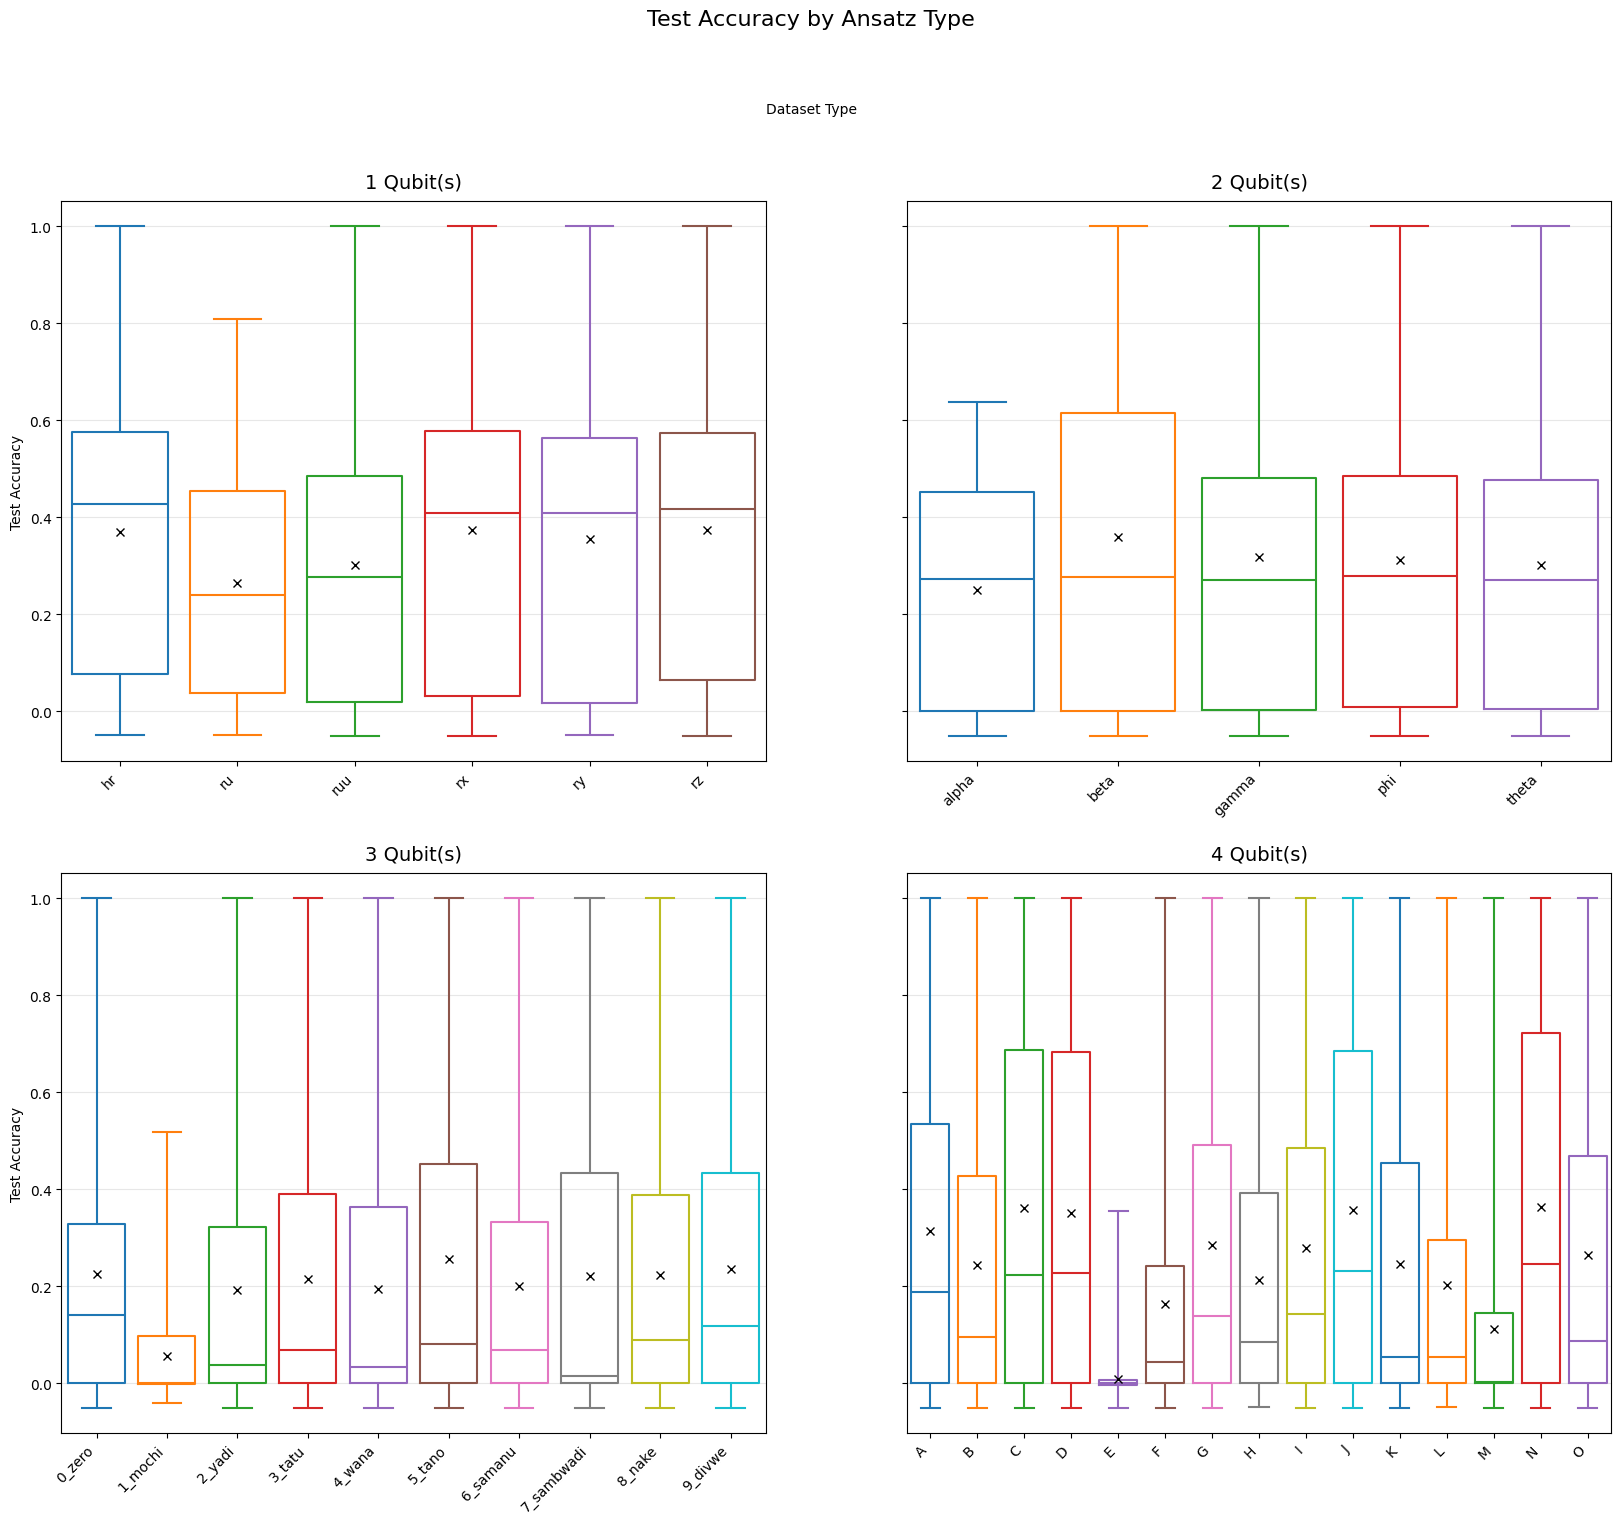

In [223]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16), sharey=True)
fig.suptitle('Test Accuracy by Ansatz Type', y=1, fontsize=16)
hue_order = ['blobs', 'circles', 'moons', 'xor']  # Your specified dataset order
palette = sns.color_palette("tab10", len(hue_order))  # Consistent colors

# Create each subplot
for q in range(1, 5):
    ax = axs[(q-1)//2, (q-1)%2]
    filtro = (complete_df['USE_BIAS'] == 'YES')  & (complete_df['Normalized'] == 'YES') & (complete_df['Qubits'] == q) # & (complete_df['noise_level'] == 'no_noise')
    df_to_plot = complete_df[filtro].sort_values(['ARQUITETURA_ANSATZ'])

    # plt.figure(figsize=(16, 8))
    sns.boxplot(
        data=df_to_plot,
        x='name',
        y='TEST_ACCURACY',
        # hue='dataset_type',
        fill=False,
        width=0.9,
        gap=0.1,
        whis=(0, 100),
        flierprops={"marker": "x"},
        showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black"},
        # hue_order=['blobs', 'circles', 'moons', 'xor'],
        ax=ax,
        palette='tab10'
    )
    # plt.grid(True, axis='y')
    ax.set_title(f'{q} Qubit(s)', fontsize=14, pad=10)
    ax.set_xlabel('')
    ax.set_ylabel('Test Accuracy' if q in [1,3] else '')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(
    handles[:len(hue_order)],  # Only show dataset_type entries
    labels[:len(hue_order)],
    title='Dataset Type',
    loc='upper center',
    bbox_to_anchor=(0.5, 0.95),
    ncol=len(hue_order),
    frameon=False
)

# Remove redundant legends
for ax in axs.flat:
    ax.get_legend().remove()

plt.tight_layout(w_pad=1)
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_15012\1069094240.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['name'] = pd.Categorical(df_to_plot['name'], categories=order_q_kl, ordered=True )
C:\Users\samue\AppData\Local\Temp\ipykernel_15012\1069094240.py:13: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  ax = sns.lineplot(


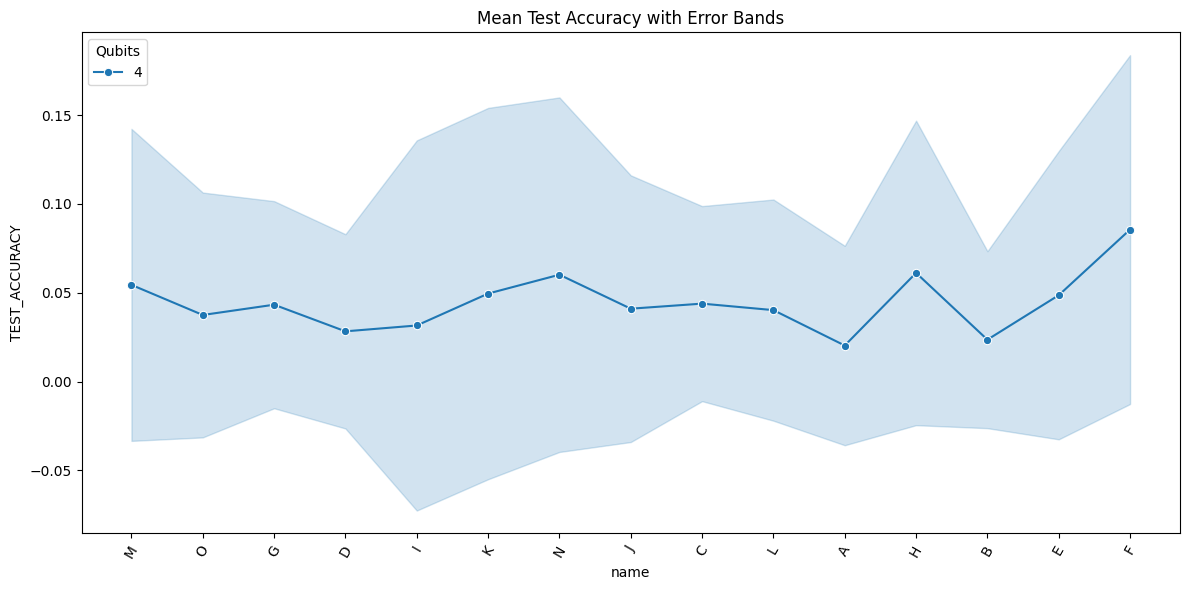

In [14]:
filtro = (complete_df['USE_BIAS'] == 'YES')  & (complete_df['Normalized'] == 'YES')  & (complete_df['noise_level'] == 'no_noise') & (complete_df['num_features'] == 16)
df_to_plot = complete_df[filtro]

order_q_kl = []
for order in ansatz_order_by_qubits:
    order_q_kl.extend(order)

df_to_plot['name'] = pd.Categorical(df_to_plot['name'], categories=order_q_kl, ordered=True )

df_to_plot2 = df_to_plot.sort_values(['name'], inplace=False)

plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_to_plot2,
    x='name',
    y='TEST_ACCURACY',
    hue='Qubits',
    estimator='mean',
    errorbar='sd',  # Show standard deviation
    err_style='band',  # Or 'bars'
    # palette='coolwarm',
    palette=sns.color_palette(n_colors=4),
    sort=False,
    marker='o'
)


plt.title('Mean Test Accuracy with Error Bands')
plt.xticks(rotation=60)
plt.tight_layout()

In [233]:
filtro = (complete_df['USE_BIAS'] == 'YES')  & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[filtro]
grouped_df = (df_to_plot.groupby(['name', 'Qubits', 'KL divergence'], as_index=False)['TEST_ACCURACY'].mean().sort_values(['Qubits', 'name']))
grouped_df

,name,Qubits,KL divergence,TEST_ACCURACY
28,hr,1,0.041942,0.369689
30,ru,1,0.045850,0.264753
31,ruu,1,0.034767,0.301919
32,rx,1,0.249244,0.374451
33,ry,1,0.233362,0.354956
34,rz,1,4.317488,0.373802
25,alpha,2,0.074536,0.250610
26,beta,2,0.027473,0.359594
27,gamma,2,0.483940,0.318678
29,phi,2,0.085627,0.312369


dataset_type                        blobs   circles     moons       xor
Qubits KL divergence name                                              
1      0.041942      hr          0.625313 -0.013490  0.518251  0.114316
       0.045850      ru          0.455512 -0.000265  0.356510  0.128415
       0.034767      ruu         0.468782 -0.002623  0.482095  0.103867
       0.249244      rx          0.653509 -0.002227  0.476015  0.075485
       0.233362      ry          0.618114 -0.015671  0.515225  0.073002
       4.317488      rz          0.643222 -0.001529  0.466117  0.119214
2      0.074536      alpha       0.378003  0.022169  0.414791 -0.007215
       0.027473      beta        0.666889 -0.001060  0.188027 -0.011611
       0.483940      gamma       0.567754  0.000899  0.081221 -0.013687
       0.085627      phi         0.494488 -0.012237  0.331160  0.003929
       0.098016      theta       0.500247 -0.003023  0.391744 -0.000585
3      0.498117      0_zero      0.371336  0.019670  0.152156  0.447667
       0.641270      1_mochi     0.112109  0.001490 -0.005640 -0.000712
       0.168725      2_yadi      0.335166  0.016882  0.009842  0.056871
       0.200875      3_tatu      0.355855  0.003388  0.076830 -0.010596
       0.054004      4_wana      0.343160  0.006203  0.043283 -0.009879
       0.032813      5_tano      0.445858  0.005878  0.133079 -0.019758
       30.222417     6_samanu    0.304340 -0.005350  0.352681  0.082341
       0.209592      7_sambwadi  0.381122  0.001431  0.038181 -0.019041
       0.040045      8_nake      0.373196 -0.000020  0.215023  0.123782
       0.023020      9_divwe     0.361792  0.007252  0.407223 -0.003243
4      0.257571      A           0.470505  0.000816  0.084252 -0.019758
       0.352285      B           0.363111  0.002803  0.159890 -0.010519
       0.153030      C           0.569203 -0.004067  0.063689 -0.019758
       0.026503      D           0.551475  0.003107  0.106155 -0.019758
       0.451511      E           0.017371 -0.021806 -0.010351  0.017864
       0.549360      F           0.255404 -0.000450  0.091032  0.059954
       0.019788      G           0.440672 -0.000164  0.134135 -0.019209
       0.330738      H           0.316846  0.005115  0.364269 -0.019840
       0.040988      I           0.403781 -0.006003  0.137588 -0.019518
       0.089093      J           0.566117  0.006783  0.094544 -0.019758
       0.044283      K           0.386534  0.007039  0.073338 -0.015681
       0.239632      L           0.345164  0.000990  0.143307  0.021604
       0.012029      M           0.133739  0.002887  0.079657  0.464260
       0.055742      N           0.546831  0.006263  0.066346 -0.014122
       0.013634      O           0.399803  0.002904  0.015391 -0.019041

C:\Users\samue\AppData\Local\Temp\ipykernel_13932\363537880.py:13: UserWarning: The palette list has more values (16) than needed (4), which may not be intended.
  lineplot = sns.lineplot(


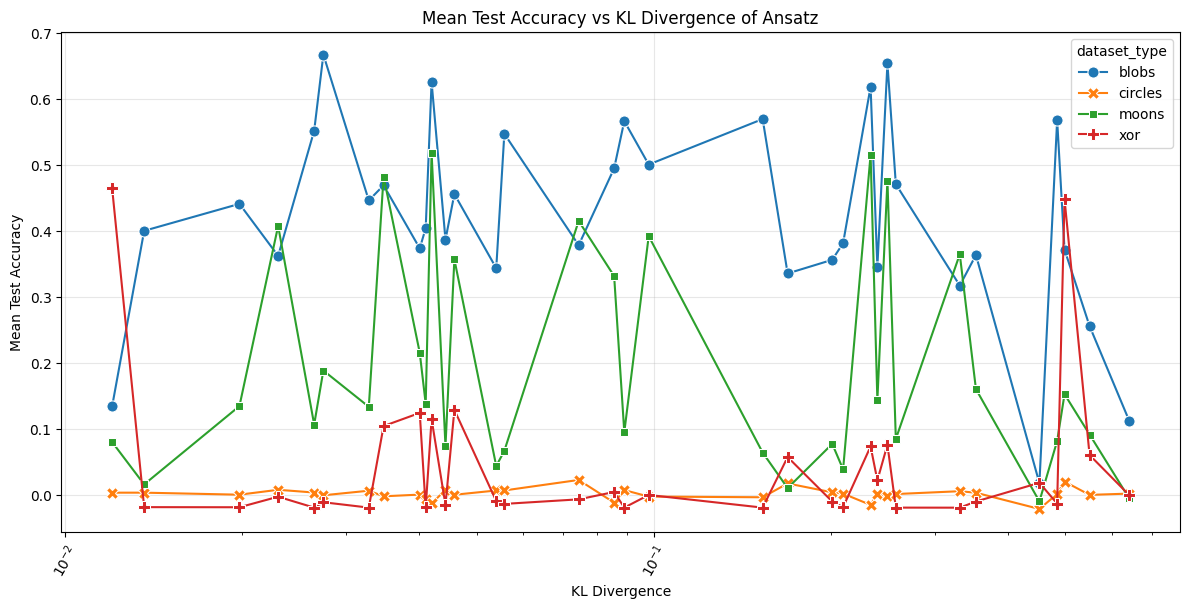

In [209]:
filtro = (complete_df['USE_BIAS'] == 'YES')  & (complete_df['Normalized'] == 'YES')  & (complete_df['noise_level'] == 'no_noise')
df_to_plot = complete_df[filtro]
grouped_df = (df_to_plot.groupby(['name', 'Qubits', 'KL divergence', 'dataset_type'], as_index=False)['TEST_ACCURACY'].mean().sort_values(['Qubits', 'name']))
grouped_df

df_to_plot = grouped_df
df_to_plot = grouped_df[grouped_df['KL divergence'] < 2 ]
plt.figure(figsize=(12, 6))

hue = df_to_plot[['Qubits', 'dataset_type']].apply(tuple, axis=1)


lineplot = sns.lineplot(
    data=df_to_plot,
    x='KL divergence',
    y='TEST_ACCURACY',
    hue='dataset_type',
    style='dataset_type',
    markers=True,
    dashes=False,
    markersize=8,
    legend='full',
    palette=sns.color_palette('tab10', n_colors=16),
)

# recuar = {'L', 'hr', 'ry', '0_zero', '2_yadi', 'I', }

# for i, row in df_to_plot.iterrows():
#     plt.text(
#         row['KL divergence'] * .99, # * (1.05 if row['name'] not in recuar else 1),
#         row['TEST_ACCURACY'] + 0.005,
#         row['name'],
#         fontsize=9.5,
#         ha='right',
#         va='bottom',
#     )
# 
plt.xscale('log')
plt.title('Mean Test Accuracy vs KL Divergence of Ansatz')
plt.xlabel('KL Divergence')
plt.ylabel('Mean Test Accuracy')
plt.grid(True, alpha=0.3)
# plt.legend(title='Number of Qubits',bbox_to_anchor=(1, 1),loc='upper left')

plt.tight_layout()
plt.xticks(rotation=60)
plt.show()

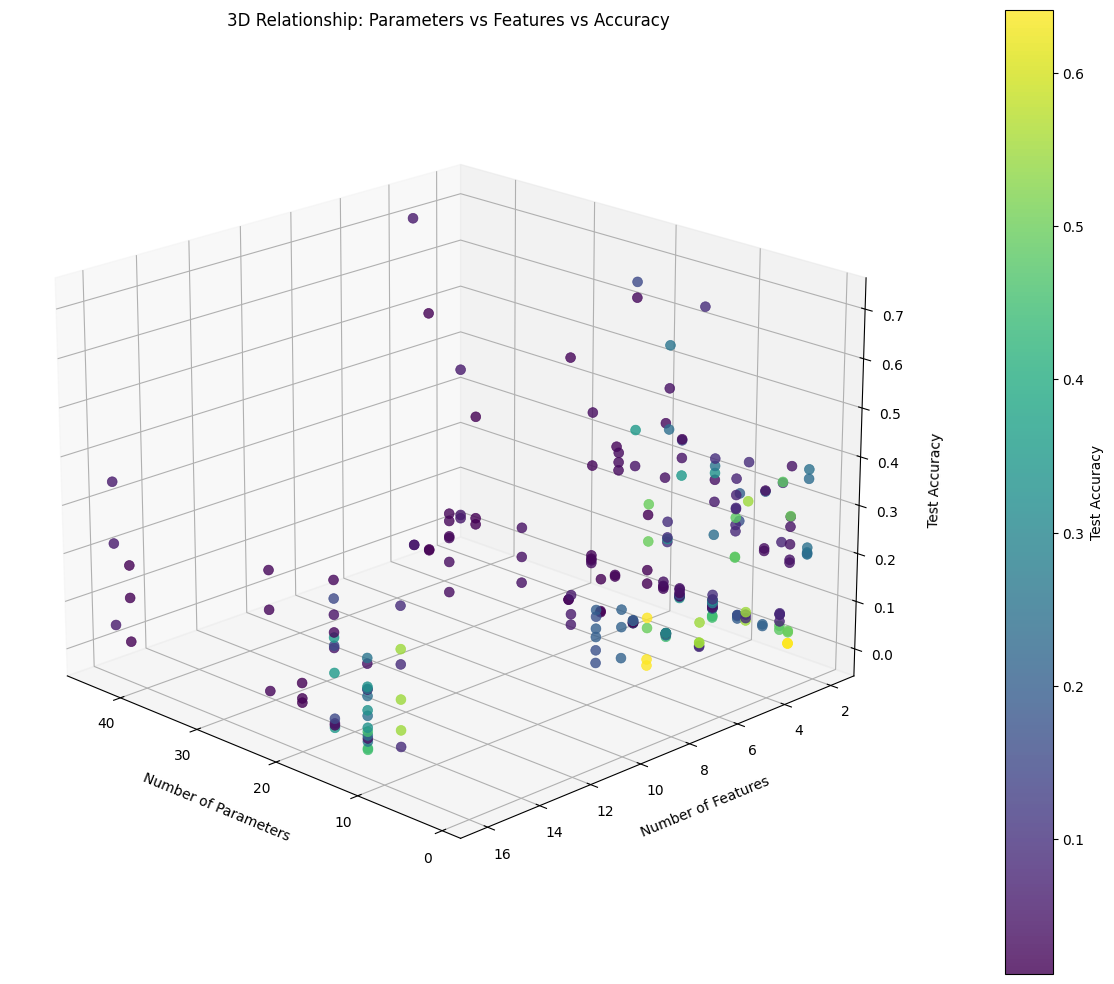

In [ ]:
import math
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[ filtro ]
df_to_plot = complete_df
grouped_df = (df_to_plot.groupby(['name', 'Qubits', 'KL divergence', 'Normalized', 'USE_BIAS', 'num_features'], as_index=False)[['TEST_ACCURACY', 'num_params']].mean().sort_values(['Qubits', 'name']))
grouped_df

df_to_plot = grouped_df
df_to_plot = grouped_df[grouped_df['KL divergence'] < 2 ]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract data
x = df_to_plot['num_params']
y = df_to_plot['num_features']
z = df_to_plot['TEST_ACCURACY']

# Create scatter plot
scatter = ax.scatter(
    x, y, z,
    c=df_to_plot['KL divergence'],  # Color by accuracy
    cmap='viridis',
    s=50,  # Marker size
    alpha=0.8,
    edgecolor='face',
    linewidth=0.5,
)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Test Accuracy')

# Label axes
ax.set_xlabel('Number of Parameters', labelpad=10)
ax.set_ylabel('Number of Features', labelpad=10)
ax.set_zlabel('Test Accuracy', labelpad=10)

# Set viewing angle
ax.view_init(elev=20, azim=135)  # Adjust these values to rotate view

# Add grid and title
ax.grid(True, alpha=0.3)
plt.title('3D Relationship: Parameters vs Features vs Accuracy', pad=20)

plt.tight_layout()
plt.show()

In [ ]:
filtro = (complete_df['USE_BIAS'] == 'YES')  & (complete_df['Normalized'] == 'YES')  & (complete_df['noise_level'] == 'no_noise')
df_to_plot = complete_df[filtro]

labels = ['ARQUITETURA_ANSATZ', 'INPUT_EMBEDDING', 'DATASET',
          'UNSUPERVISED_METRIC', 'Qubits', 'dataset_type', 
          'num_classes', 'num_features', 'num_samples', 'noise_level']
values = [ 'TRAIN_METRIC_COST', 'TEST_METRIC_COST', 'TRAIN_ACCURACY', 'TEST_ACCURACY', 'KL divergence']

grouped_df = (df_to_plot.groupby(labels, as_index=False)[values].mean().sort_values(['ARQUITETURA_ANSATZ']))

grouped_df

In [48]:
filtro = (complete_df['USE_BIAS'] == 'YES')  & (complete_df['Normalized'] == 'YES')  & (complete_df['noise_level'] == 'no_noise')
filtro = filtro & (complete_df['num_samples'] > 50)
df_to_plot = complete_df[filtro]

# UNSUPERVISED_METRIC
labels = ['dataset_type', 'DATASET', 'INPUT_EMBEDDING', 'num_classes', 'num_features', 'Qubits', 'ARQUITETURA_ANSATZ']
values = [ 'TRAIN_ACCURACY', 'TEST_ACCURACY', 'KL divergence', 'TRAIN_METRIC_COST', 'TEST_METRIC_COST']


grouped_df = (df_to_plot.groupby(labels, as_index=False)[values].mean().sort_values(['ARQUITETURA_ANSATZ']))

grouped_df
NUM_TOP = 10

top_by_dataset = (
    grouped_df.sort_values('TEST_ACCURACY', ascending=False)
    .groupby('DATASET')
    .head(NUM_TOP)
    .sort_values(['DATASET', 'TEST_ACCURACY'], ascending=[True, False])
)

top_by_dataset

,dataset_type,DATASET,INPUT_EMBEDDING,num_classes,num_features,Qubits,ARQUITETURA_ANSATZ,TRAIN_ACCURACY,TEST_ACCURACY,KL divergence,TRAIN_METRIC_COST,TEST_METRIC_COST
5,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,F,0.166985,0.166019,0.549360,4.463981,4.466521
8,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,I,0.100098,0.111369,0.040988,1.472174,1.495240
9,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,J,0.101628,0.107103,0.089093,3.479024,3.490767
4,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,E,0.076960,0.066165,0.451511,5.471496,5.472498
6,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,G,0.057968,0.056560,0.019788,5.472801,5.473617
...,...,...,...,...,...,...,...,...,...,...,...,...
334,xor,xor_500samples_no_noise,phasex,2,2,3,8_nake,0.115923,0.121348,0.040045,4.304359,4.301931
315,xor,xor_500samples_no_noise,amplitude,2,2,1,hr,0.092088,0.106198,0.041942,1.317744,1.319615
332,xor,xor_500samples_no_noise,phasex,2,2,3,6_samanu,0.098219,0.103511,30.222417,1.318702,1.322319
319,xor,xor_500samples_no_noise,amplitude,2,2,1,ry,0.056169,0.042093,0.233362,1.312184,1.315677


In [41]:
top_by_dataset.style.background_gradient(
    subset=['TEST_ACCURACY'], cmap='Greens'
).set_caption("Top 3 combinações por DATASET com maior TEST_ACCURACY")


,dataset_type,DATASET,INPUT_EMBEDDING,num_classes,num_features,Qubits,ARQUITETURA_ANSATZ,TRAIN_ACCURACY,TEST_ACCURACY,KL divergence,TRAIN_METRIC_COST,TEST_METRIC_COST
5,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,F,0.166985,0.166019,0.549360,4.463981,4.466521
8,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,I,0.100098,0.111369,0.040988,1.472174,1.495240
9,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,J,0.101628,0.107103,0.089093,3.479024,3.490767
49,blobs,blobs_2classes_2features_500samples_no_noise,phasex,2,2,4,N,1.000000,1.000000,0.055742,0.154835,0.163753
23,blobs,blobs_2classes_2features_500samples_no_noise,phasex,2,2,2,gamma,1.000000,1.000000,0.483940,0.154835,0.163753
31,blobs,blobs_2classes_2features_500samples_no_noise,phasex,2,2,3,5_tano,1.000000,1.000000,0.032813,0.154835,0.163753
56,blobs,blobs_2classes_4features_500samples_no_noise,phasex,2,4,4,A,1.000000,1.000000,0.257571,0.258220,0.255612
58,blobs,blobs_2classes_4features_500samples_no_noise,phasex,2,4,4,C,1.000000,1.000000,0.153030,0.258220,0.255612
65,blobs,blobs_2classes_4features_500samples_no_noise,phasex,2,4,4,J,0.999184,1.000000,0.089093,0.258221,0.255612
79,blobs,blobs_2classes_8features_500samples_no_noise,amplitude,2,8,3,8_nake,0.558180,0.595387,0.040045,0.386644,0.388522


In [49]:
filtro = (top_by_dataset['dataset_type'] != 'blobs')
df_to_plot = top_by_dataset #[filtro]

unique_datasets = df_to_plot['DATASET'].unique()
palette = sns.color_palette("tab10", len(unique_datasets)).as_hex()

# Mapeia cada dataset para uma cor da paleta
dataset_color_map = {
    dataset: palette[i] for i, dataset in enumerate(unique_datasets)
}

def color_dataset_rows(row):
    color = dataset_color_map[row['DATASET']]
    return [f'background-color: {color}'] * len(row)

styled = (
    df_to_plot.style
    .apply(color_dataset_rows, axis=1)
    .background_gradient(
        subset=['TEST_ACCURACY', 'TRAIN_ACCURACY', 'KL divergence', 'Qubits'],
        cmap='Greens',
        # vmax=1,
    )
    .set_caption("Top 3 combinações por DATASET com maior TEST_ACCURACY")
)

styled

,dataset_type,DATASET,INPUT_EMBEDDING,num_classes,num_features,Qubits,ARQUITETURA_ANSATZ,TRAIN_ACCURACY,TEST_ACCURACY,KL divergence,TRAIN_METRIC_COST,TEST_METRIC_COST
5,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,F,0.166985,0.166019,0.549360,4.463981,4.466521
8,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,I,0.100098,0.111369,0.040988,1.472174,1.495240
9,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,J,0.101628,0.107103,0.089093,3.479024,3.490767
4,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,E,0.076960,0.066165,0.451511,5.471496,5.472498
6,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,G,0.057968,0.056560,0.019788,5.472801,5.473617
11,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,L,0.055891,0.051009,0.239632,5.474638,5.477480
7,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,H,0.057180,0.041374,0.330738,5.474497,5.476282
1,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,B,0.043545,0.033642,0.352285,3.506145,3.513937
13,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,N,0.031085,0.026728,0.055742,3.499021,3.509031
12,blobs,blobs_2classes_16features_500samples_no_noise,amplitude,2,16,4,M,0.014763,0.015623,0.012029,5.479019,5.483151


In [45]:
# Colunas que você quer manter na exibição
visible_columns = ['DATASET', 'num_classes', 'num_features', 'ARQUITETURA_ANSATZ', 'TEST_ACCURACY']

# Seleciona apenas essas colunas
df_to_plot_visible = df_to_plot[visible_columns]

# Gera o mapa de cores por DATASET
unique_datasets = df_to_plot_visible['DATASET'].unique()
palette = sns.color_palette("tab10", len(unique_datasets)).as_hex()
dataset_color_map = {dataset: palette[i] for i, dataset in enumerate(unique_datasets)}

# Função de estilização por linha
def color_dataset_rows(row):
    color = dataset_color_map[row['DATASET']]
    return [f'background-color: {color}'] * len(row)

# Estilo da tabela
styled = (
    df_to_plot_visible.style
    .apply(color_dataset_rows, axis=1)
    .background_gradient(
        subset=['TEST_ACCURACY'],
        cmap='Greens',
    )
    .set_caption("Top 3 combinações por DATASET com maior TEST_ACCURACY")
)

styled


,DATASET,num_classes,num_features,ARQUITETURA_ANSATZ,TEST_ACCURACY
5,blobs_2classes_16features_500samples_no_noise,2,16,F,0.166019
8,blobs_2classes_16features_500samples_no_noise,2,16,I,0.111369
9,blobs_2classes_16features_500samples_no_noise,2,16,J,0.107103
49,blobs_2classes_2features_500samples_no_noise,2,2,N,1.000000
23,blobs_2classes_2features_500samples_no_noise,2,2,gamma,1.000000
31,blobs_2classes_2features_500samples_no_noise,2,2,5_tano,1.000000
56,blobs_2classes_4features_500samples_no_noise,2,4,A,1.000000
58,blobs_2classes_4features_500samples_no_noise,2,4,C,1.000000
65,blobs_2classes_4features_500samples_no_noise,2,4,J,1.000000
79,blobs_2classes_8features_500samples_no_noise,2,8,8_nake,0.595387


In [123]:
top_by_dataset[['ARQUITETURA_ANSATZ', 'Qubits', 'KL divergence']].value_counts()

ARQUITETURA_ANSATZ  Qubits  KL divergence
N                   4       0.0557           5
0_zero              3       0.4981           3
9_divwe             3       0.0230           3
F                   4       0.5494           2
2_yadi              3       0.1687           2
M                   4       0.0120           2
beta                2       0.0275           2
C                   4       0.1530           2
A                   4       0.2576           1
H                   4       0.3307           1
G                   4       0.0198           1
8_nake              3       0.0400           1
J                   4       0.0891           1
I                   4       0.0410           1
gamma               2       0.4839           1
hr                  1       0.0419           1
ruu                 1       0.0348           1
Name: count, dtype: int64

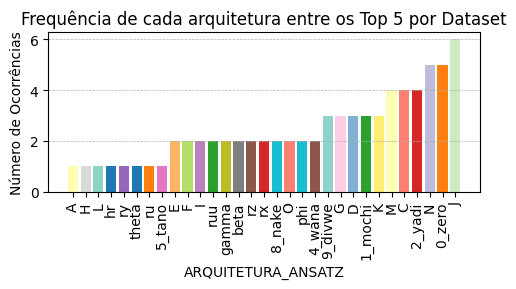

In [178]:
# Contagem das aparições por arquitetura
arquitetura_counts = top_by_dataset['ARQUITETURA_ANSATZ'].value_counts().sort_values()

palette_30 = sns.color_palette("tab10", 20) + sns.color_palette("Set3", 20)
arquitetura_color_map = {name: palette_30[i] for i, name in enumerate(all_arquiteturas)}

# Extrai apenas as que aparecem no dataset com a cor certa
arquiteturas_presentes = arquitetura_counts.index
cores_presentes = [arquitetura_color_map[arch] for arch in arquiteturas_presentes]

plt.figure(figsize=(5, 3))
plt.bar(
    arquitetura_counts.index,
    arquitetura_counts.values,
    # palette='Set2'
    color=cores_presentes,
)

plt.ylabel('Número de Ocorrências')
plt.xlabel('ARQUITETURA_ANSATZ')
plt.title(f'Frequência de cada arquitetura entre os Top {NUM_TOP} por Dataset')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



C:\Users\samue\AppData\Local\Temp\ipykernel_15012\3441378346.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




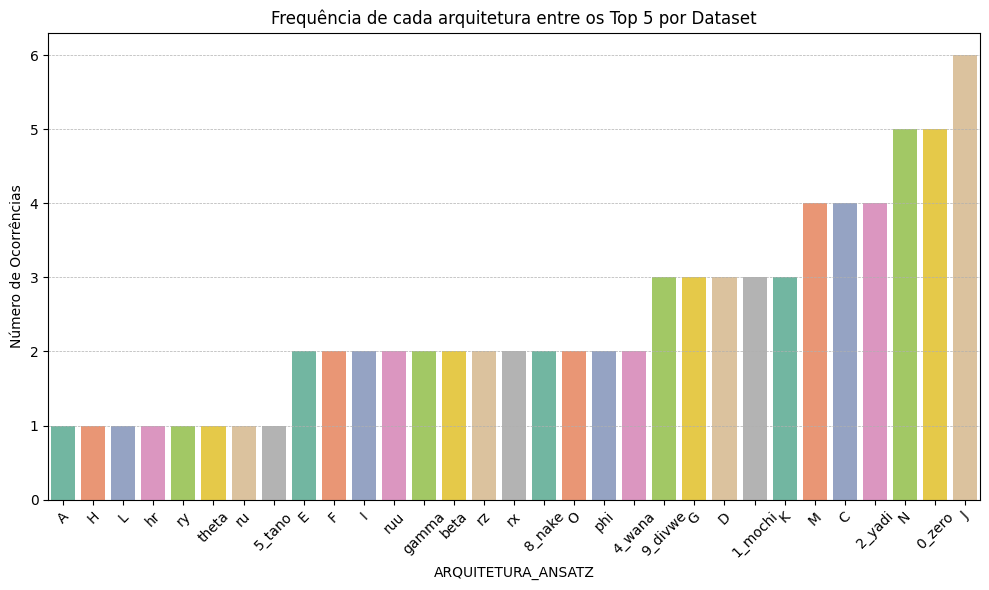

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem das aparições por arquitetura
arquitetura_counts = top_by_dataset['ARQUITETURA_ANSATZ'].value_counts().sort_values()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=arquitetura_counts.index,
    y=arquitetura_counts.values,
    palette='Set2'
)

plt.ylabel('Número de Ocorrências')
plt.xlabel('ARQUITETURA_ANSATZ')
plt.title(f'Frequência de cada arquitetura entre os Top {NUM_TOP} por Dataset')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [59]:
import plotly.io as pio
pio.renderers.default = 'browser'

fig = px.scatter(
    top3_by_dataset,
    x="dataset_type",
    y="TEST_ACCURACY",
    color="ARQUITETURA_ANSATZ",
    symbol="UNSUPERVISED_METRIC",
    size="num_features",
    hover_data=["INPUT_EMBEDDING", "num_classes"]
)
fig.show()


C:\Users\samue\AppData\Local\Temp\ipykernel_15012\3634648648.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\samue\AppData\Local\Temp\ipykernel_15012\3634648648.py:5: UserWarning:


The palette list has fewer values (30) than needed (36) and will cycle, which may produce an uninterpretable plot.



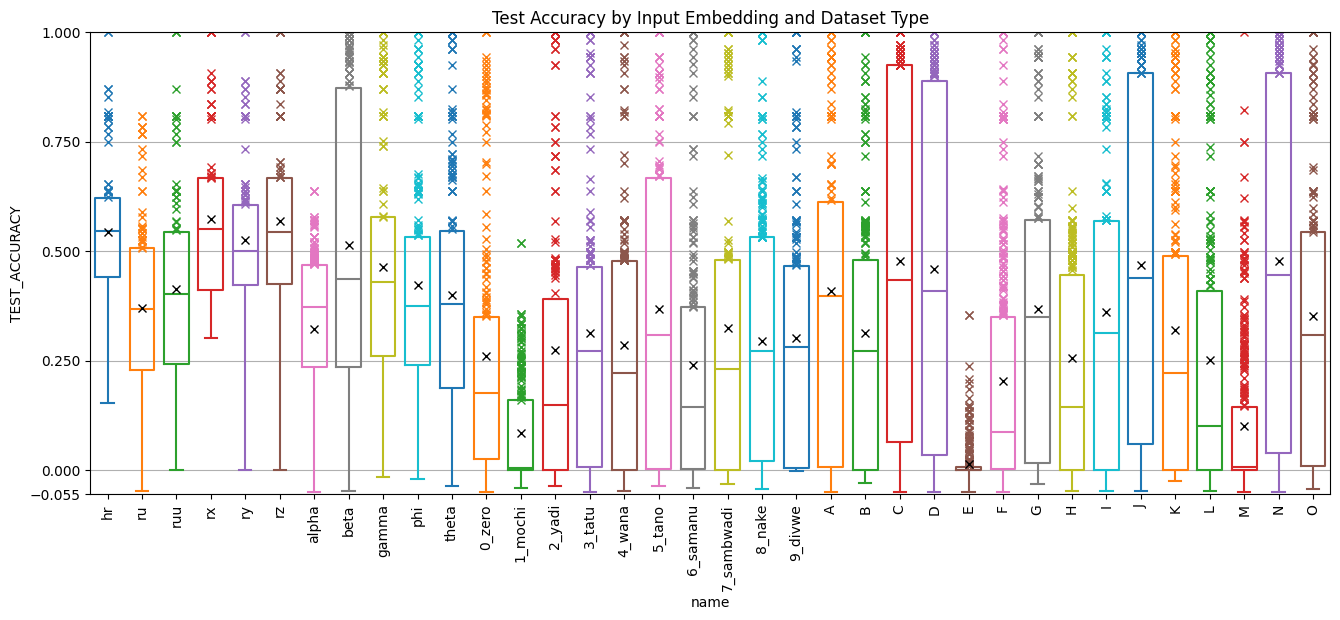

In [217]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES') & (complete_df['dataset_type'] == 'blobs') # & (complete_df['INPUT_EMBEDDING'] == 'phasex')
df_to_plot = complete_df[filtro].sort_values(['dataset_type'])

plt.figure(figsize=(16, 6))
sns.boxplot(
    data=df_to_plot,
    x='name',
    y='TEST_ACCURACY',
    # hue='INPUT_EMBEDDING',
    fill=False,
    gap=0.1,
    whis=(0, 2),
    flierprops={"marker": "x"},
    showmeans=True, 
    meanprops={"marker":"x", "markeredgecolor":"black"},
    palette=sns.color_palette('tab10', 30),
    order=all_arquiteturas
    # hue_order=['blobs', 'circles', 'moons', 'xor'],
)

plt.title("Test Accuracy by Input Embedding and Dataset Type")
plt.ylim(-0.025, 1)
plt.yticks([-0.055, 0, 0.25, 0.5, 0.75, 1])
plt.grid(True, axis='y')
plt.xticks(rotation=90)
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_20192\3481525698.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\samue\AppData\Local\Temp\ipykernel_20192\3481525698.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(short_arq)
C:\Users\samue\AppData\Local\Temp\ipykernel_20192\3481525698.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\samue\AppData\Local\Temp\ipykernel_20192\3481525698.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(short_arq)
C:\Users\sam

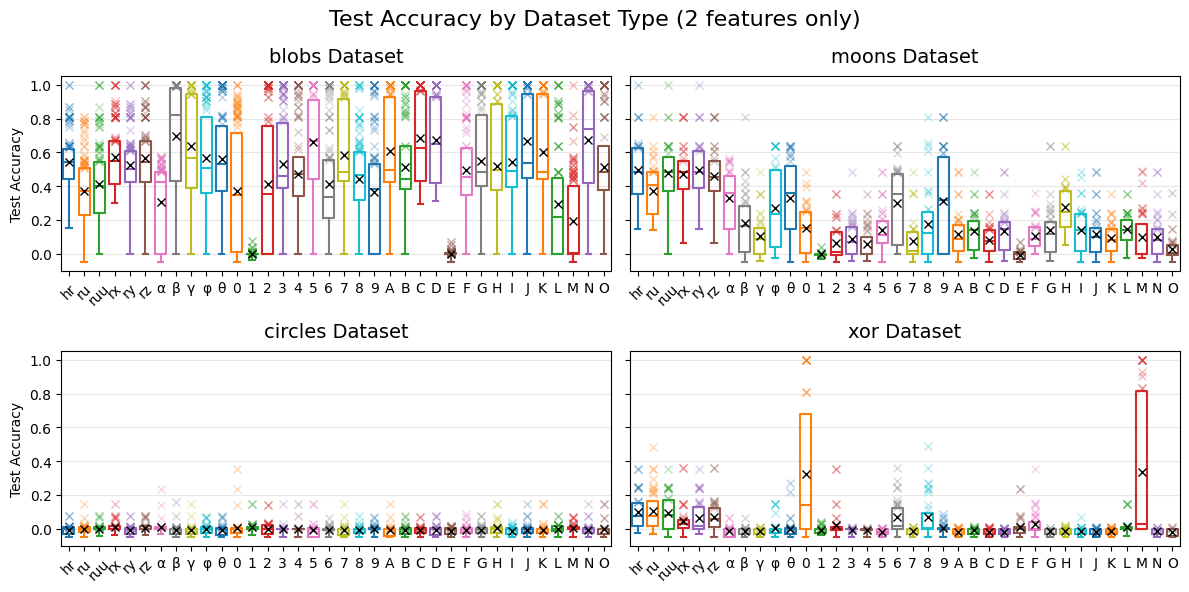

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Test Accuracy by Dataset Type (2 features only)', fontsize=16) #y=1
subset_order = ['xor','blobs', 'moons', 'circles']  # Your specified dataset order

filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES') & (complete_df['num_features'] == 2)
df_to_plot = complete_df[filtro].sort_values(['dataset_type'])

for q, tp in enumerate(subset_order):
    ax = axs[(q-1)//2, (q-1)%2]
    df_to_plot_ = df_to_plot[df_to_plot['dataset_type'] == tp]

    sns.boxplot(
        data=df_to_plot_,
        ax=ax,
        x='name',
        y='TEST_ACCURACY',
        # hue='name',
        fill=False,
        gap=0.1,
        whis=(0, 2),
        flierprops={"marker": "x", "alpha": 0.3},
        showmeans=True, 
        meanprops={"marker":"x", "markeredgecolor":"black"},
        palette=sns.color_palette('tab10', 36),
        order=all_arquiteturas
    )

    ax.set_title(f'{tp} Dataset', fontsize=14, pad=10)
    ax.set_xlabel('')
    ax.set_ylabel('Test Accuracy' if q in [1,3] else '')
    ax.grid(True, axis='y', alpha=0.3)

    ax.set_xticklabels(short_arq)

    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        if len(label.get_text()) > 1:
            label.set_rotation(45)

# axs[0, 0].set_xticklabels(short_arq)
# axs[0, 1].set_xticklabels(short_arq)
plt.tight_layout(w_pad=1)
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_20192\3816452677.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\samue\AppData\Local\Temp\ipykernel_20192\3816452677.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(short_arq)
C:\Users\samue\AppData\Local\Temp\ipykernel_20192\3816452677.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\samue\AppData\Local\Temp\ipykernel_20192\3816452677.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(short_arq)
C:\Users\sam

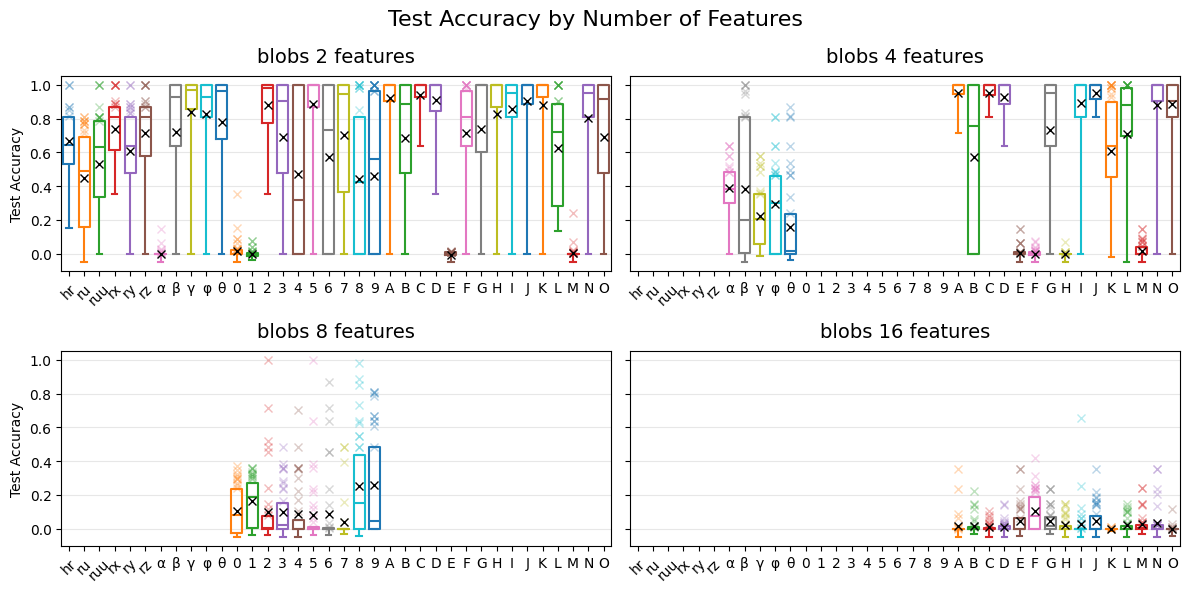

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True)
fig.suptitle('Test Accuracy by Number of Features', fontsize=16) #y=1

filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES') & (complete_df['dataset_type'] == 'blobs') & (complete_df['num_classes'] == 2)
df_to_plot = complete_df[filtro].sort_values(['dataset_type'])

for q in range(1, 5):
    ax = axs[(q-1)//2, (q-1)%2]
    df_to_plot_ = df_to_plot[(df_to_plot['num_features'] == 2**q)]

    sns.boxplot(
        data=df_to_plot_,
        ax=ax,
        x='name',
        y='TEST_ACCURACY',
        # hue='num_classes',
        fill=False,
        gap=0.1,
        whis=(0, 2),
        flierprops={"marker": "x", "alpha": 0.3},
        showmeans=True, 
        meanprops={"marker":"x", "markeredgecolor":"black"},
        palette=sns.color_palette('tab10', 36),
        order=all_arquiteturas
    )

    ax.set_title(f'blobs {2**q} features', fontsize=14, pad=10)
    ax.set_xlabel('')
    ax.set_ylabel('Test Accuracy' if q in [1,3] else '')
    ax.grid(True, axis='y', alpha=0.3)

    ax.set_xticklabels(short_arq)

    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        if len(label.get_text()) > 1:
            label.set_rotation(45)

# axs[0, 0].set_xticklabels(short_arq)
# axs[0, 1].set_xticklabels(short_arq)
plt.tight_layout(w_pad=1)
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_15012\3667520426.py:5: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.



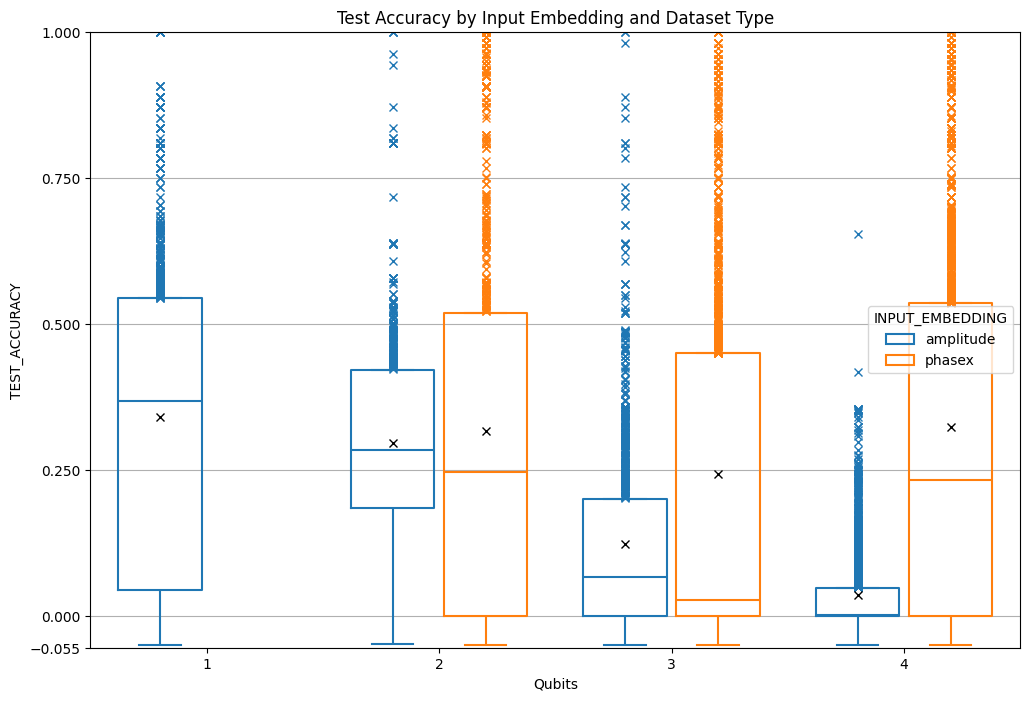

In [ ]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[filtro].sort_values(['dataset_type'])

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_to_plot,
    x='Qubits',
    y='TEST_ACCURACY',
    hue='INPUT_EMBEDDING',
    fill=False,
    gap=0.1,
    whis=(0, 2),
    flierprops={"marker": "x"},
    showmeans=True, 
    meanprops={"marker":"x", "markeredgecolor":"black"},
    palette=sns.color_palette('tab10', n_colors=4),
    # hue_order=['blobs', 'circles', 'moons', 'xor'],
)

plt.title("Test Accuracy by Input Embedding and Dataset Type")
plt.ylim(-0.025, 1)
plt.yticks([-0.055, 0, 0.25, 0.5, 0.75, 1])
plt.grid(True, axis='y')
plt.show()

# Final Plots

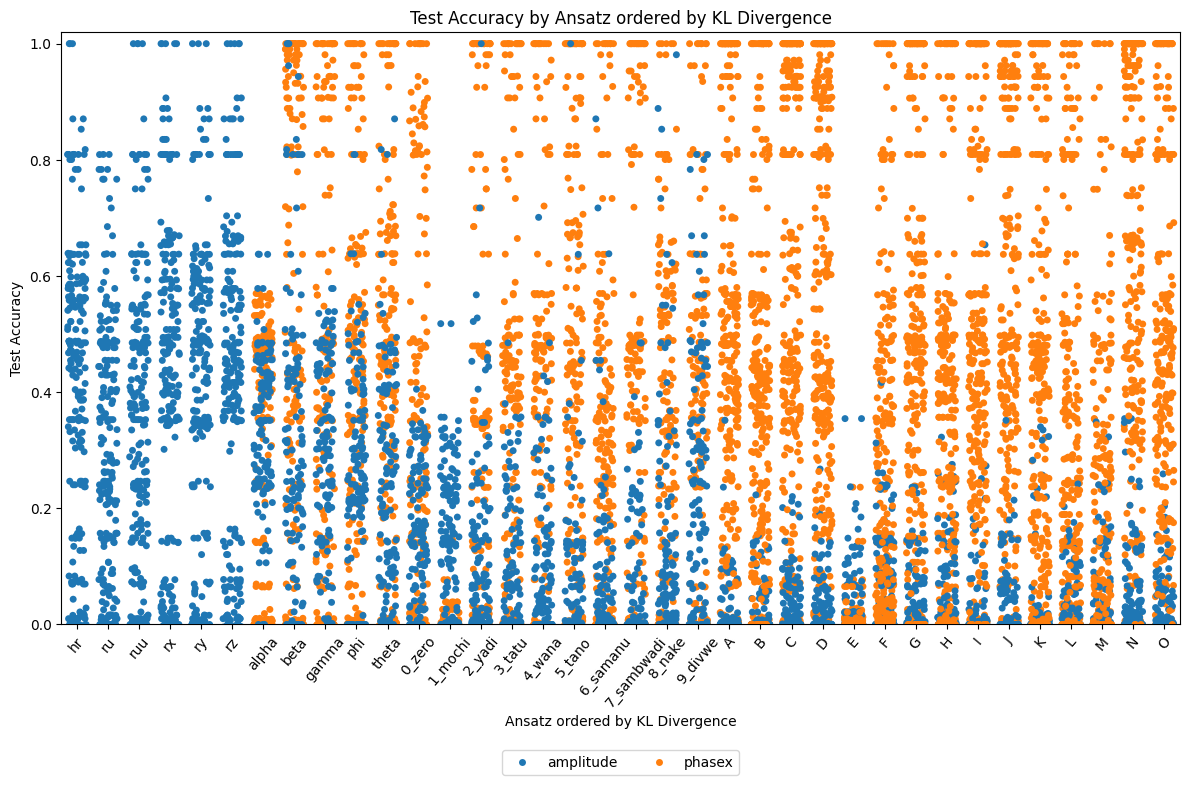

In [327]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[ filtro ]
ansatz_order = ansatz_df.sort_values(['Qubits', 'name'])['name']

plt.figure(figsize=(12, 8))
scatter = sns.stripplot(data=df_to_plot, x='name', y='TEST_ACCURACY', 
                          hue='INPUT_EMBEDDING',
                          jitter=0.3,
                          palette=sns.color_palette('tab10', n_colors=2),
                          order=ansatz_order,
                          )
plt.xticks(rotation=50)
# Set x-axis limits
# plt.xlim(0, 0.65)
plt.ylim(0, 1.02)
# plt.xscale('log')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center',ncol=2 )
plt.title('Test Accuracy by Ansatz ordered by KL Divergence')
plt.xlabel('Ansatz ordered by KL Divergence')
plt.ylabel('Test Accuracy')
plt.tight_layout()
plt.show()

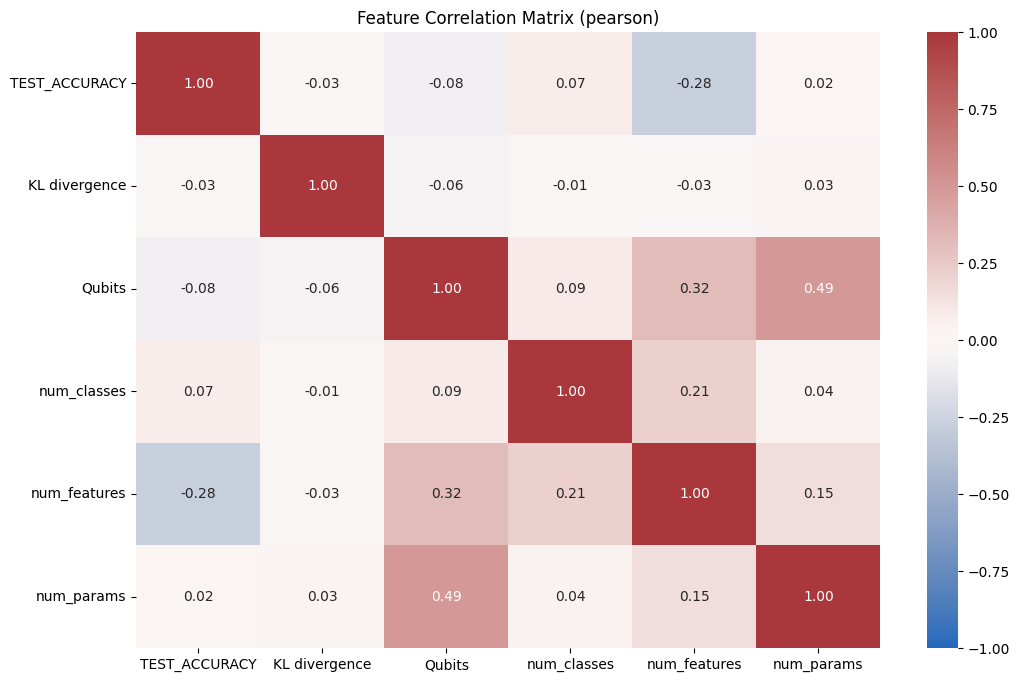

In [328]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == "YES")
df_to_plot = complete_df[ filtro ]
numeric_cols = ['TEST_ACCURACY', 'KL divergence', 'Qubits', 'num_classes', 'num_features', 'num_params']

plt.figure(figsize=(12, 8))
corr_matrix = df_to_plot[numeric_cols].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='vlag', center=0, fmt=".2f", vmin=-1)
plt.title("Feature Correlation Matrix (pearson)")
plt.show()

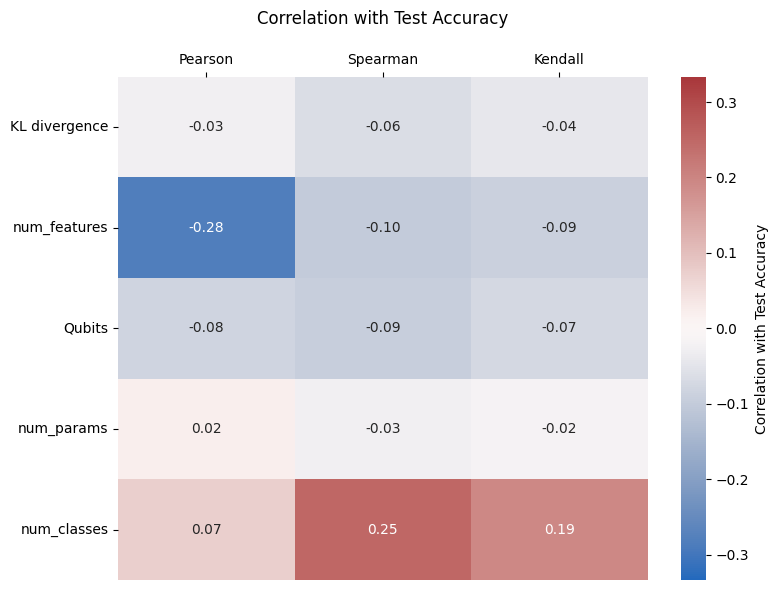

In [331]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[filtro]

numeric_cols = ['TEST_ACCURACY', 'KL divergence', 'num_features', 'Qubits', 'num_params', 'num_classes']

# Calculate correlation matrix
corr_matrix   =   df_to_plot[numeric_cols].corr(method='pearson')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Pearson'})
corr_matrix = corr_matrix.join( df_to_plot[numeric_cols].corr(method='spearman')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Spearman'}) )
corr_matrix = corr_matrix.join( df_to_plot[numeric_cols].corr(method='kendall')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Kendall'}) )

corr_matrix = corr_matrix.drop('TEST_ACCURACY')

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='vlag', center=0, fmt=".2f", 
            vmin=-1/3, vmax=1/3, cbar_kws={'label': 'Correlation with Test Accuracy'})

plt.title("Correlation with Test Accuracy\n")
# plt.yticks(rotation=0)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()

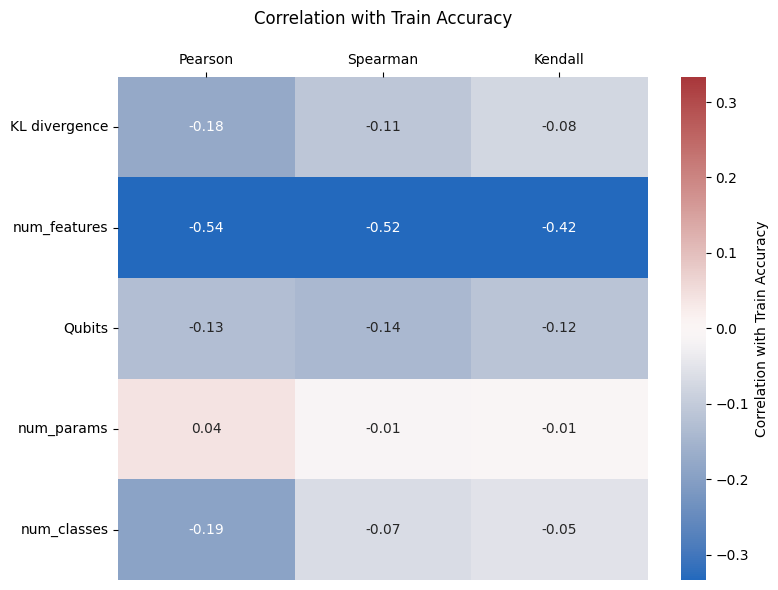

In [ ]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[filtro]

numeric_cols = ['TRAIN_ACCURACY', 'KL divergence', 'num_features', 'Qubits', 'num_params', 'num_classes']

# Calculate correlation matrix
corr_matrix   =   df_to_plot[numeric_cols].corr(method='pearson')[['TRAIN_ACCURACY']].rename(columns={'TRAIN_ACCURACY': 'Pearson'})
corr_matrix = corr_matrix.join( df_to_plot[numeric_cols].corr(method='spearman')[['TRAIN_ACCURACY']].rename(columns={'TRAIN_ACCURACY': 'Spearman'}) )
corr_matrix = corr_matrix.join( df_to_plot[numeric_cols].corr(method='kendall')[['TRAIN_ACCURACY']].rename(columns={'TRAIN_ACCURACY': 'Kendall'}) )

corr_matrix = corr_matrix.drop('TRAIN_ACCURACY')

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='vlag', center=0, fmt=".2f", 
            vmin=-1/3, vmax=1/3, cbar_kws={'label': 'Correlation with Train Accuracy'})

plt.title("Correlation with Train Accuracy\n")
# plt.yticks(rotation=0)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()

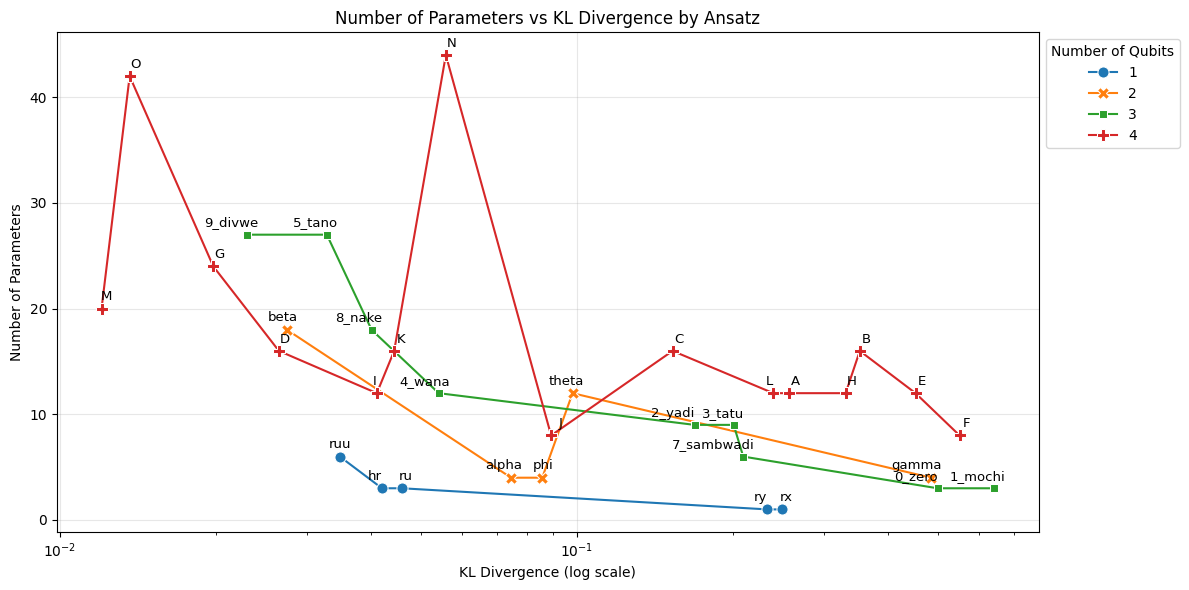

In [336]:
df_to_plot = ansatz_df[ansatz_df['KL divergence'] < 2]
plt.figure(figsize=(12, 6))

lineplot = sns.lineplot(
    data=df_to_plot,
    x='KL divergence',
    y='num_params',
    hue='Qubits',
    style='Qubits',
    markers=True,
    dashes=False,
    markersize=8,
    legend='full',
    palette=sns.color_palette('tab10', n_colors=4),
)

recuar = {'L', 'hr', 'ry', '0_zero', '2_yadi', 'I', }

for i, row in df_to_plot.iterrows():
    plt.text(
        row['KL divergence'] * (1.05 if row['name'] not in recuar else 1),
        row['num_params']+0.5,
        row['name'],
        fontsize=9.5,
        ha='right',
        va='bottom',
    )
# 
plt.xscale('log')
plt.title('Number of Parameters vs KL Divergence by Ansatz')
plt.xlabel('KL Divergence (log scale)')
plt.ylabel('Number of Parameters')
plt.grid(True, alpha=0.3)
plt.legend(title='Number of Qubits',bbox_to_anchor=(1, 1),loc='upper left')

plt.tight_layout()
plt.show()

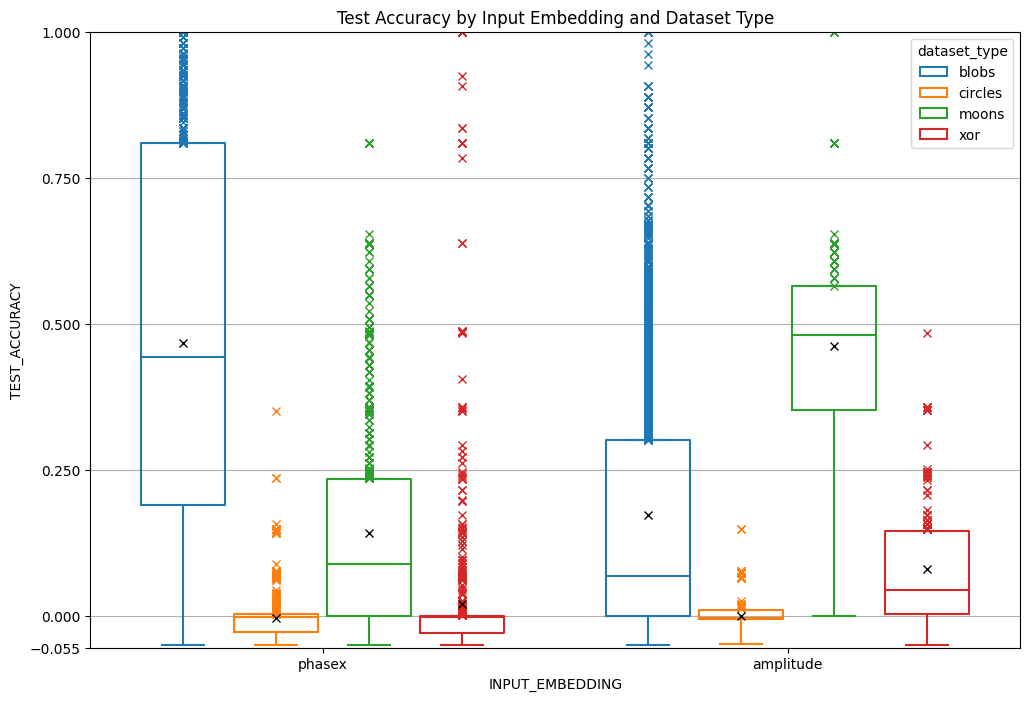

In [337]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[filtro].sort_values(['dataset_type'])

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_to_plot,
    x='INPUT_EMBEDDING',
    y='TEST_ACCURACY',
    hue='dataset_type',
    fill=False,
    gap=0.1,
    whis=(0, 2),
    flierprops={"marker": "x"},
    showmeans=True, 
    meanprops={"marker":"x", "markeredgecolor":"black"},
    palette=sns.color_palette('tab10', n_colors=4),
    hue_order=['blobs', 'circles', 'moons', 'xor'],
)

plt.title("Test Accuracy by Input Embedding and Dataset Type")
plt.ylim(-0.025, 1)
plt.yticks([-0.055, 0, 0.25, 0.5, 0.75, 1])
plt.grid(True, axis='y')
plt.show()

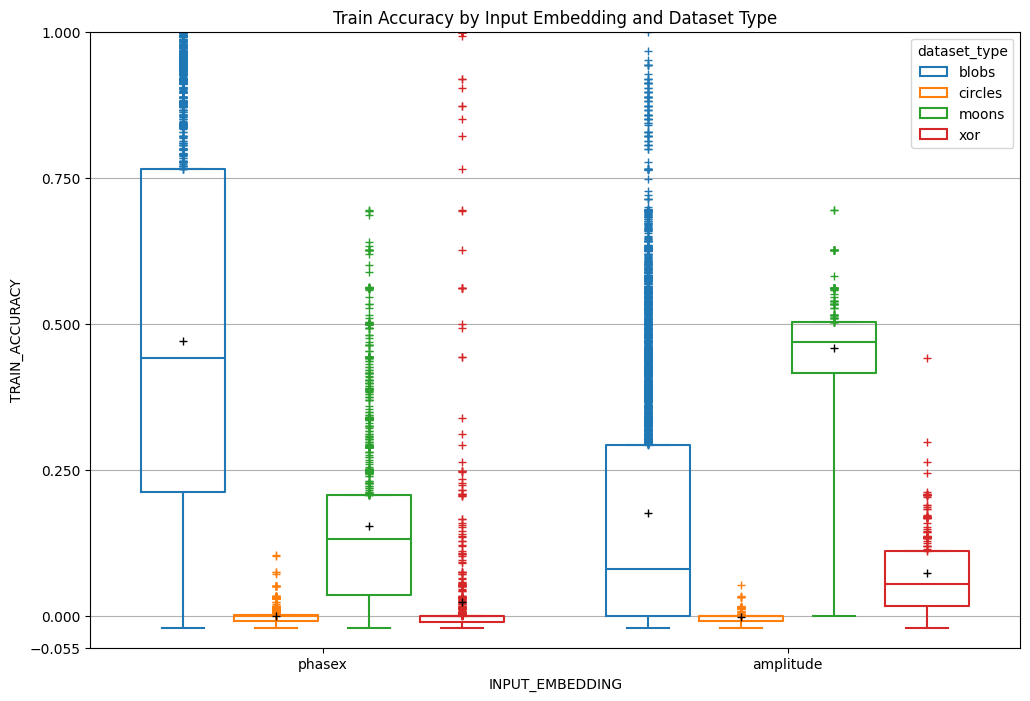

In [70]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[filtro].sort_values(['dataset_type'])

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_to_plot,
    x='INPUT_EMBEDDING',
    y='TRAIN_ACCURACY',
    hue='dataset_type',
    fill=False,
    gap=0.1,
    whis=(0, 2),
    flierprops={"marker": "+"},
    showmeans=True, 
    meanprops={"marker":'+', "markeredgecolor":"black"},
    palette=sns.color_palette('tab10', n_colors=4),
    hue_order=['blobs', 'circles', 'moons', 'xor'],
)

plt.title("Train Accuracy by Input Embedding and Dataset Type")
plt.ylim(-0.025, 1)
plt.yticks([-0.055, 0, 0.25, 0.5, 0.75, 1])
plt.grid(True, axis='y')
plt.show()

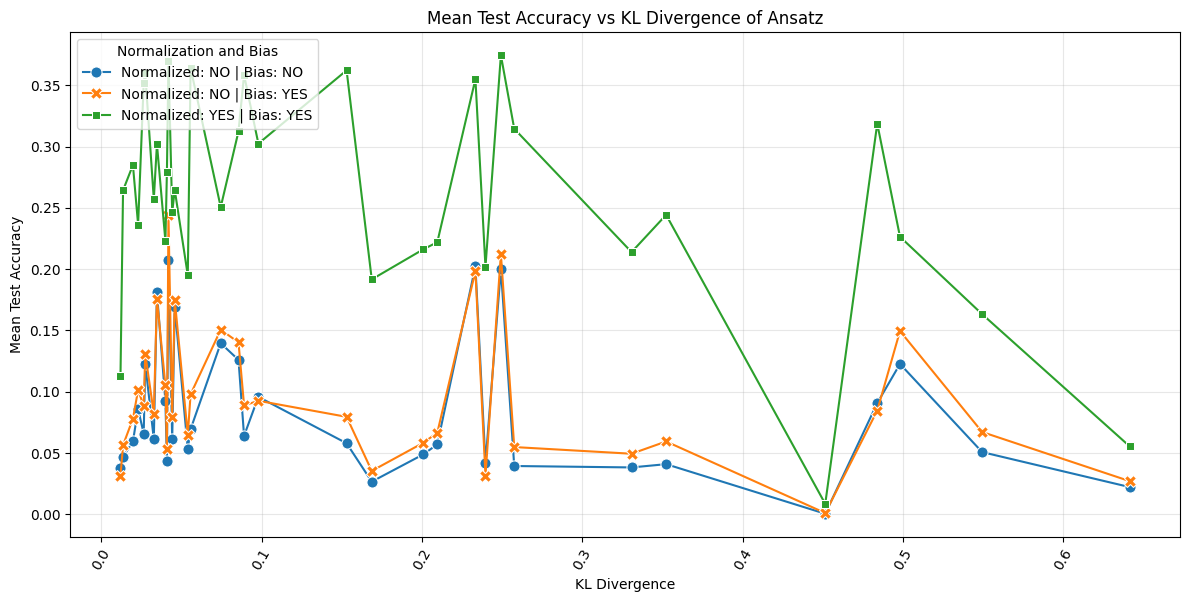

In [342]:
df_to_plot = complete_df
grouped_df = (df_to_plot.groupby(['name', 'Qubits', 'KL divergence', 'Normalized', 'USE_BIAS'], as_index=False)[['TEST_ACCURACY', 'TRAIN_ACCURACY']].mean().sort_values(['Qubits', 'name']))
grouped_df

df_to_plot = grouped_df
df_to_plot = grouped_df[grouped_df['KL divergence'] < 2 ]
plt.figure(figsize=(12, 6))

def slaf(a):
    a, b = a
    return 'Normalized: ' + a + ' | ' + 'Bias: ' + b

hue = df_to_plot[['Normalized', 'USE_BIAS']].apply(slaf, axis=1)

ax = sns.lineplot(
    data=df_to_plot,
    x='KL divergence',
    y='TEST_ACCURACY',
    hue=hue,
    style=hue,
    markers=True,
    dashes=False,
    markersize=8,
    palette=sns.color_palette('tab10', n_colors=3),
)
 
plt.title('Mean Test Accuracy vs KL Divergence of Ansatz')
plt.xlabel('KL Divergence')
plt.ylabel('Mean Test Accuracy')
plt.grid(True, alpha=0.3)

plt.legend(title='Normalization and Bias', loc='upper left')

plt.tight_layout()
plt.xticks(rotation=60)
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_13932\1869607220.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df_to_plot.groupby(['name', 'Qubits', 'KL divergence', 'noise_level'], as_index=False)['TEST_ACCURACY'].mean()


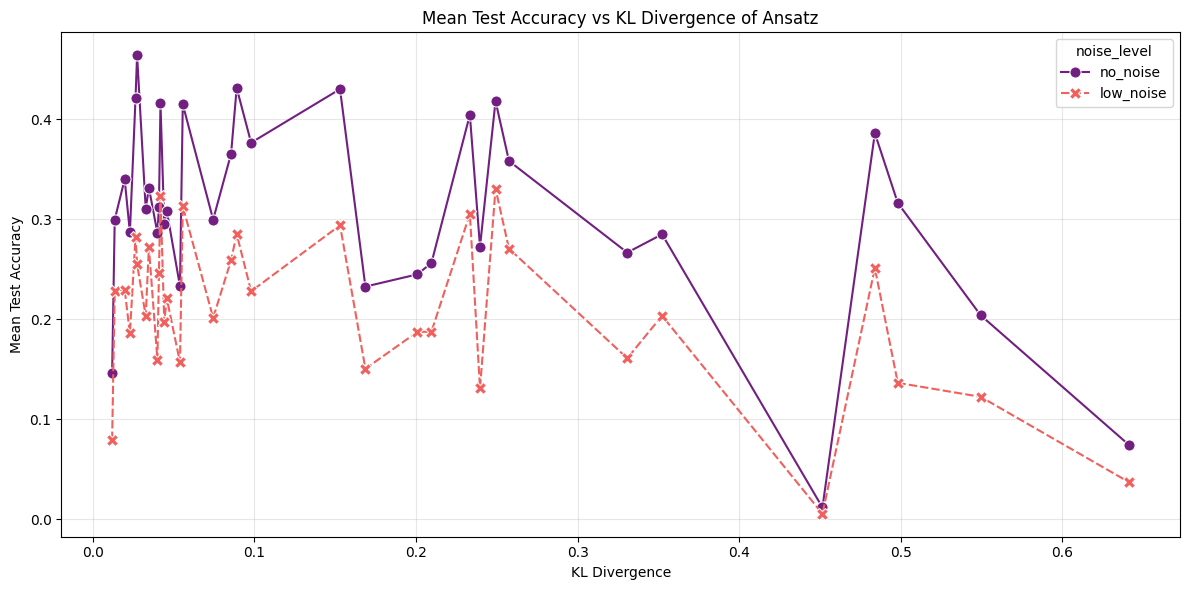

In [346]:
filtro = (complete_df['USE_BIAS'] == 'YES')  & (complete_df['Normalized'] == 'YES')  #& (complete_df['noise_level'] == 'no_noise')
df_to_plot = complete_df[filtro]
grouped_df = df_to_plot.groupby(['name', 'Qubits', 'KL divergence', 'noise_level'], as_index=False)['TEST_ACCURACY'].mean()
grouped_df

df_to_plot = grouped_df
df_to_plot = grouped_df[grouped_df['KL divergence'] < 2 ]
plt.figure(figsize=(12, 6))

lineplot = sns.lineplot(
    data=df_to_plot,
    x='KL divergence',
    y='TEST_ACCURACY',
    hue='noise_level',
    style='noise_level',
    markers=True,
    dashes=True,
    markersize=8,
    legend='full',
    palette=sns.color_palette('magma', n_colors=2),
)

plt.title('Mean Test Accuracy vs KL Divergence of Ansatz')
plt.xlabel('KL Divergence')
plt.ylabel('Mean Test Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

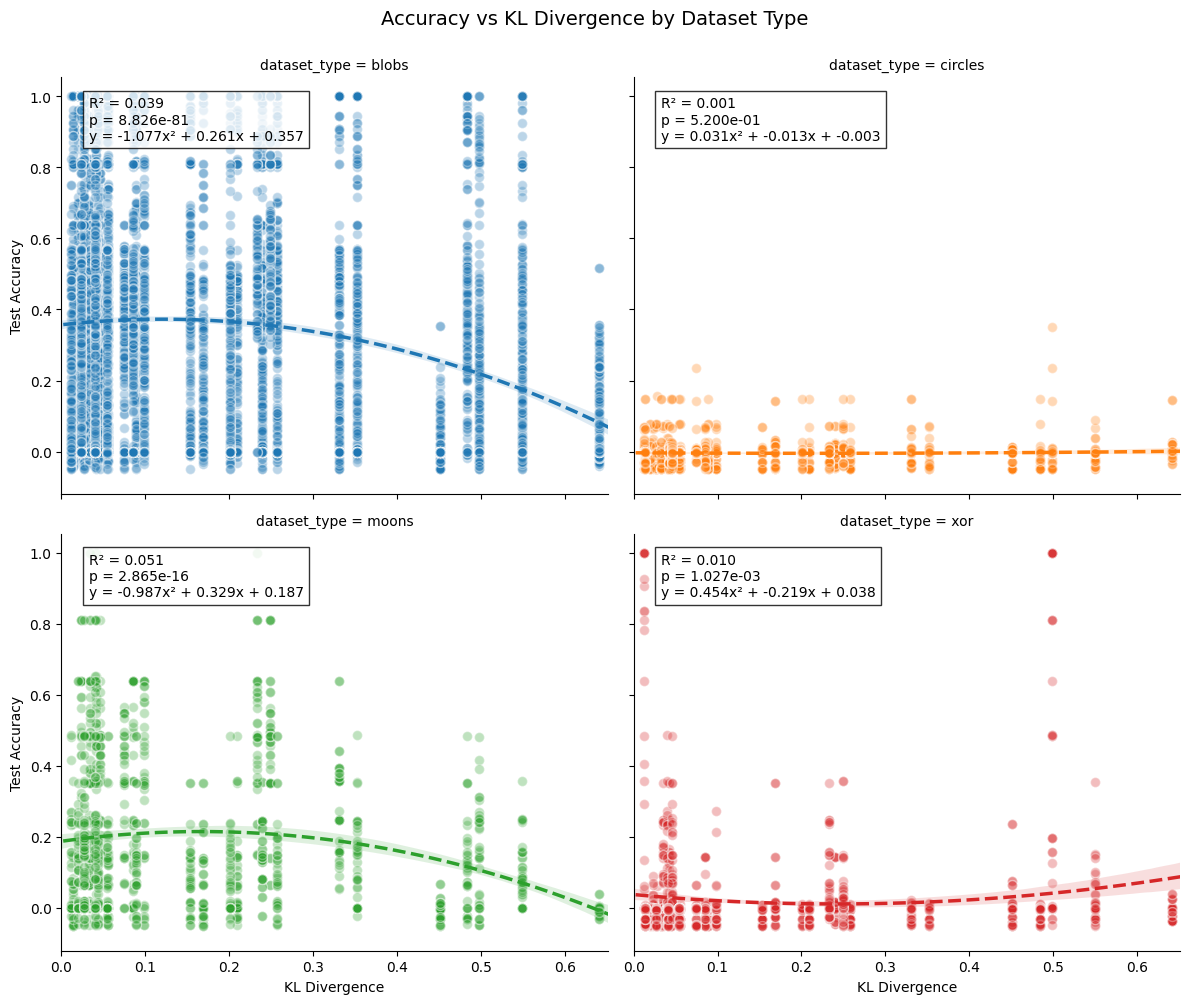

In [ ]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES') & (complete_df['num_samples'] >= 100 )
df_to_plot = complete_df[ filtro ].sort_values(['dataset_type'])
df_to_plot = df_to_plot[df_to_plot['KL divergence'] < 2]

plt.figure(figsize=(12, 12))

ax = sns.lmplot(
    data=df_to_plot,
    x='KL divergence',
    y='TEST_ACCURACY',
    hue='dataset_type',
    col='dataset_type',
    col_wrap=2, 
    height=5,
    aspect=1.2,
    scatter_kws={'alpha': 0.3, 's': 50, 'edgecolor': 'w'},
    line_kws={'lw': 2.5, 'ls': '--'},
    ci=95,
    truncate=False,
    order=2,
    palette=sns.color_palette('tab10', n_colors=4),
)

for i, dataset in enumerate(df_to_plot['dataset_type'].unique()):
    subset = df_to_plot[df_to_plot['dataset_type'] == dataset]
    
    coeffs = np.polyfit( subset['KL divergence'], subset['TEST_ACCURACY'], 2)
    
    r_squared = np.corrcoef( subset['TEST_ACCURACY'], np.polyval(coeffs, subset['KL divergence']) )[0,1]**2
    
    residuals = subset['TEST_ACCURACY'] - np.polyval(coeffs, subset['KL divergence'])
    dof = len(subset) - 3 
    mse = np.sum(residuals**2) / dof

    p_value = stats.f.sf( (r_squared/(1-r_squared))*(dof/2), 2, dof )
    
    ax.axes[i].text(
        0.05, 0.85,  # Adjusted position
        f"R² = {r_squared:.3f}\np = {p_value:.3e}\ny = {coeffs[0]:.3f}x² + {coeffs[1]:.3f}x + {coeffs[2]:.3f}",
        transform=ax.axes[i].transAxes,
        bbox=dict(facecolor='white', alpha=0.8, pad=4),
        fontsize=10
    )


ax.set(xlim=(0, df_to_plot['KL divergence'].max()+0.01))
ax.set_axis_labels("KL Divergence", "Test Accuracy")
plt.suptitle("Accuracy vs KL Divergence by Dataset Type", y=1.0, fontsize=14)
plt.tight_layout()
plt.show()

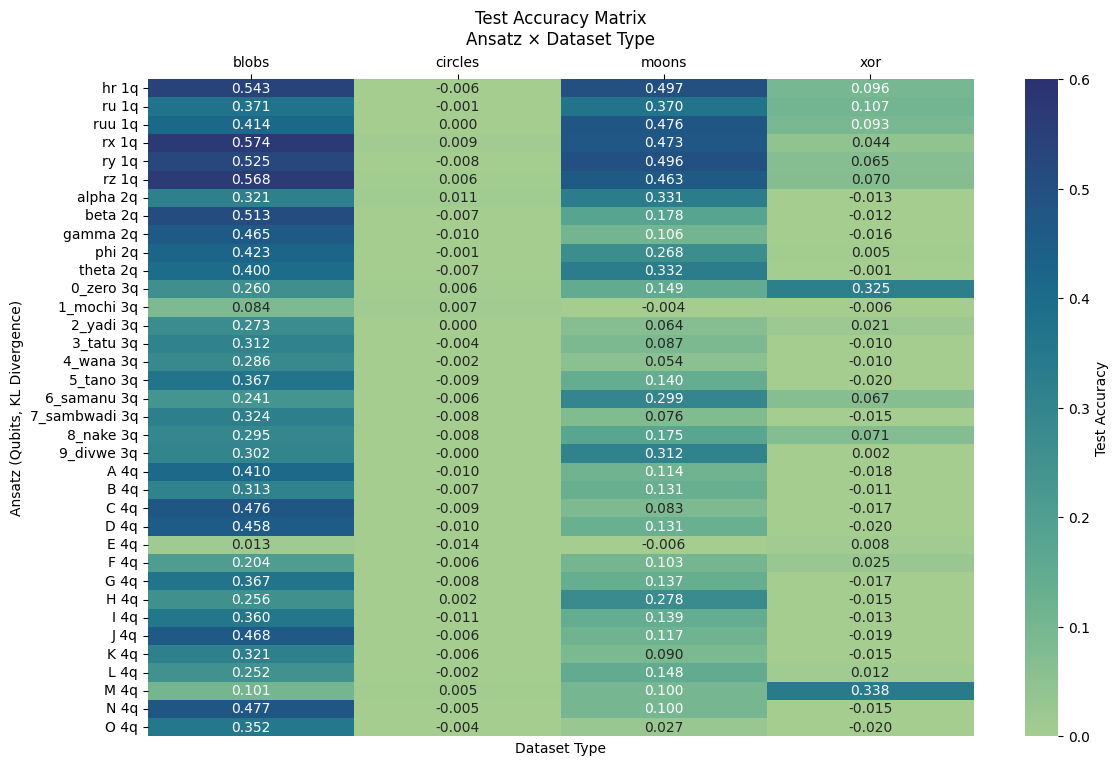

In [348]:
filtro = (complete_df['USE_BIAS'] == 'YES')  & (complete_df['Normalized'] == 'YES') 
df_to_plot = complete_df[filtro].sort_values(['Qubits', 'ARQUITETURA_ANSATZ'])

pivot_table = df_to_plot.pivot_table(
    values='TEST_ACCURACY',
    index=['Qubits', 'KL divergence', 'name'],  # Multi-index rows
    columns='dataset_type',
    aggfunc='mean'
).sort_values(['Qubits', 'name'])

plt.figure(figsize=(12, 8))

pivot_table = pivot_table.reset_index()
pivot_table['label'] = pivot_table.apply(
    lambda x: f"{x['name']} {x['Qubits']}q", 
    axis=1
)

sns.heatmap(
    pivot_table.set_index('label')[['blobs', 'circles', 'moons', 'xor']],
    annot=True,
    fmt=".3f",
    cmap="crest",
    cbar_kws={'label': 'Test Accuracy'},
    vmin=0, vmax=0.6,
)

plt.title("Test Accuracy Matrix\nAnsatz × Dataset Type", pad=25)
plt.xlabel("Dataset Type")
plt.ylabel("Ansatz (Qubits, KL Divergence)")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.show()


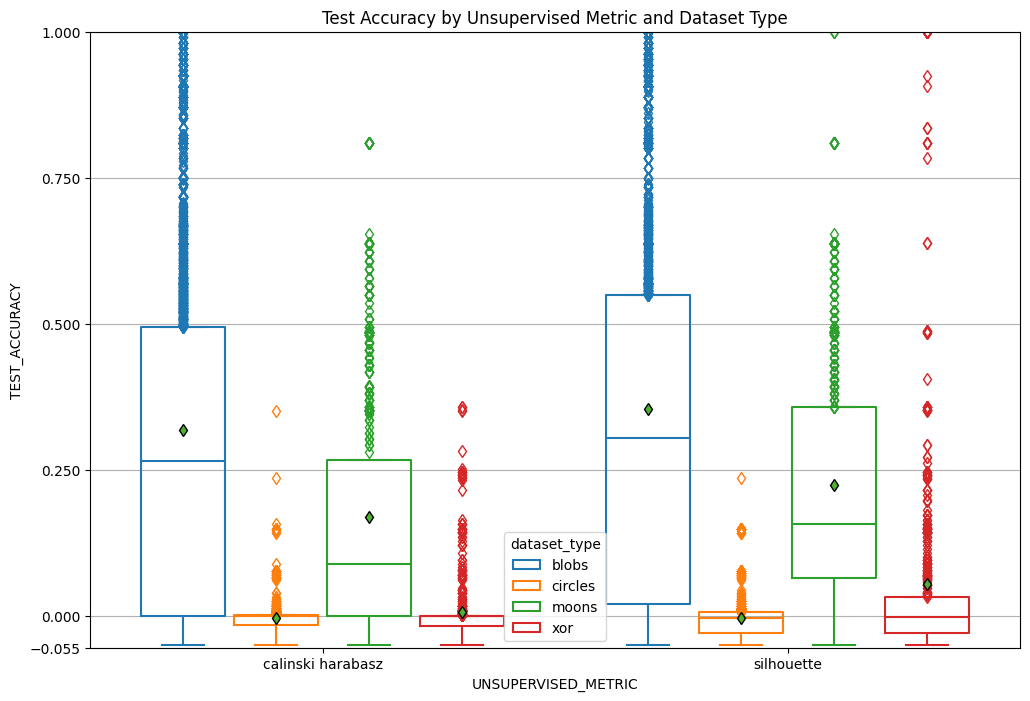

In [359]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[filtro].sort_values(['dataset_type'])

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_to_plot,
    x='UNSUPERVISED_METRIC',
    y='TEST_ACCURACY',
    hue='dataset_type',
    fill=False,
    gap=0.1,
    whis=(0, 2),
    flierprops={"marker": "d"},
    showmeans=True, 
    meanprops={"marker":"d", "markeredgecolor":"black"},
    palette=sns.color_palette('tab10', n_colors=4),
    hue_order=['blobs', 'circles', 'moons', 'xor'],
)

plt.title("Test Accuracy by Unsupervised Metric and Dataset Type")
plt.ylim(-0.025, 1)
plt.yticks([-0.055, 0, 0.25, 0.5, 0.75, 1])
plt.grid(True, axis='y')
plt.show()

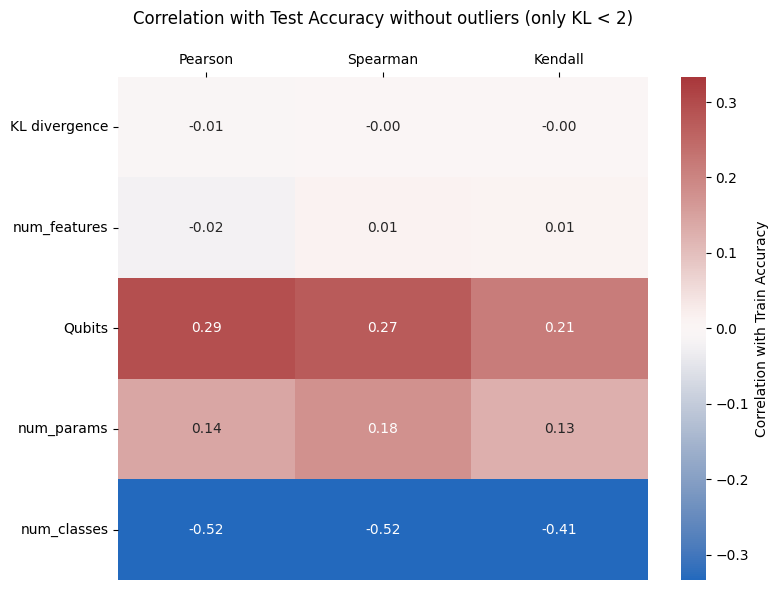

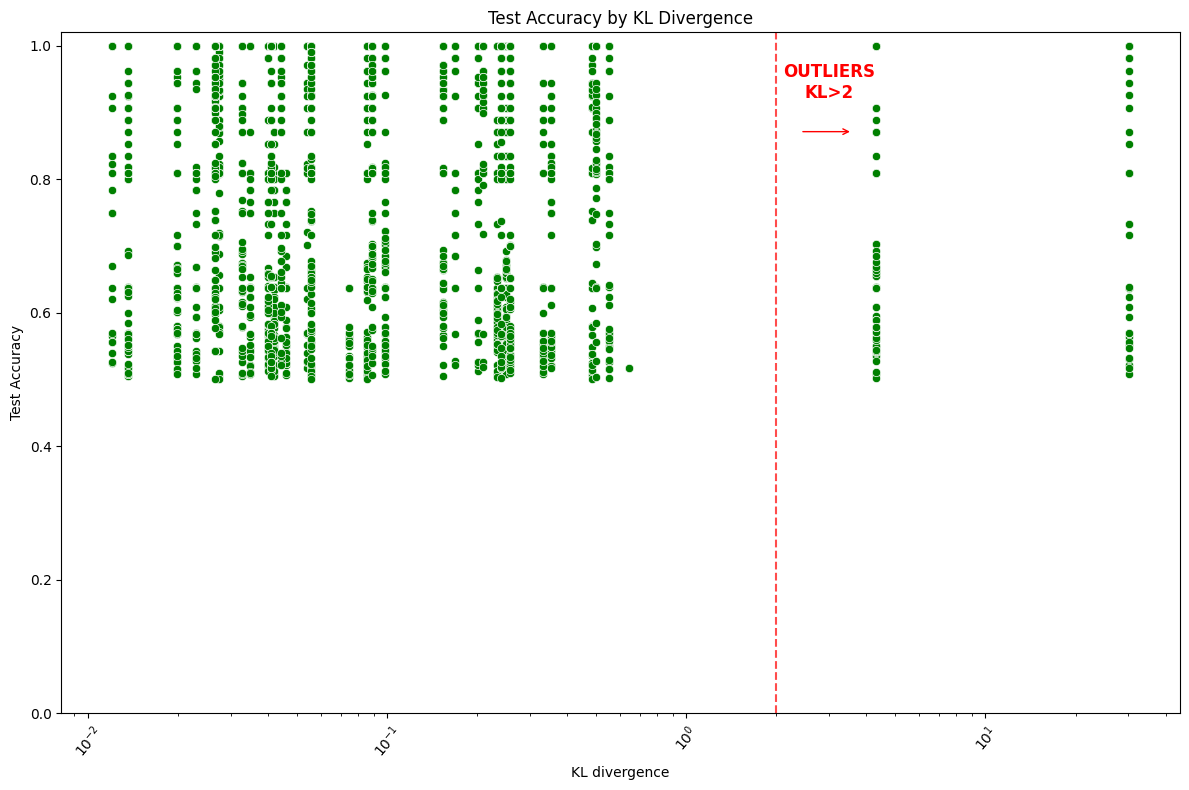

In [ ]:
filtro = (complete_df['USE_BIAS'] == 'YES') & (complete_df['Normalized'] == 'YES')
df_to_plot = complete_df[filtro].copy()



df_to_plot_BEFORE = df_to_plot
KLMAX = 2
df_to_plot = df_to_plot[df_to_plot['KL divergence'] < KLMAX]

numeric_cols = ['TEST_ACCURACY', 'KL divergence', 'num_features', 'Qubits', 'num_params', 'num_classes']

# Calculate correlation matrix
corr_matrix   =   df_to_plot[numeric_cols].corr(method='pearson')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Pearson'})
corr_matrix = corr_matrix.join( df_to_plot[numeric_cols].corr(method='spearman')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Spearman'}) )
corr_matrix = corr_matrix.join( df_to_plot[numeric_cols].corr(method='kendall')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Kendall'}) )

corr_matrix = corr_matrix.drop('TEST_ACCURACY')

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='vlag', center=0, fmt=".2f", 
            vmin=-1/3, vmax=1/3, cbar_kws={'label': 'Correlation with Train Accuracy'})

plt.title(f"Correlation with Test Accuracy without outliers (only KL < {KLMAX})\n")
# plt.yticks(rotation=0)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()


df_to_plot = df_to_plot_BEFORE
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_to_plot, x='KL divergence', y='TEST_ACCURACY', color='g')

plt.axvline(
    x=KLMAX,
    color='red',linestyle='--',
    linewidth=1.5, alpha=0.7,
)

plt.text(
    KLMAX*1.5, plt.ylim()[1]*0.95, 
    f"OUTLIERS\nKL>{KLMAX}",
    fontsize=12,color='red',weight='bold',ha='center',va='top',
)
plt.annotate(
    '',
    xy=(KLMAX*1.8, plt.ylim()[1]*0.85),
    xytext=(KLMAX*1.2, plt.ylim()[1]*0.85),
    arrowprops=dict(arrowstyle='->', color='red', linewidth=1)
)


plt.xticks(rotation=50)
plt.ylim(0, 1.02)
plt.xscale('log')
plt.title('Test Accuracy by KL Divergence')
plt.ylabel('Test Accuracy')
plt.tight_layout()
plt.show()

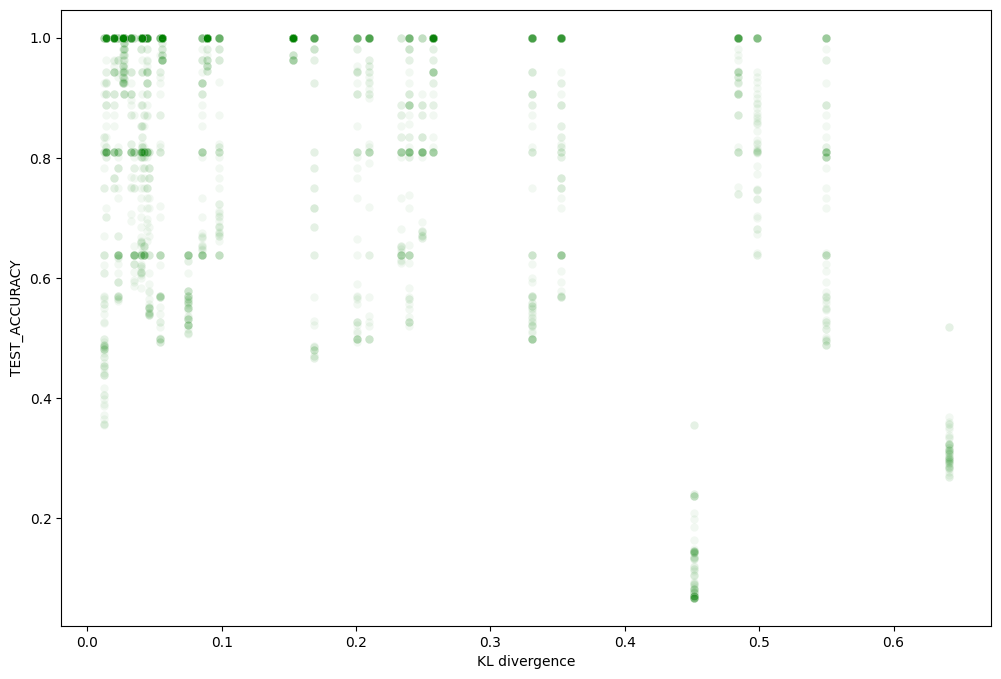

In [ ]:
mask = (complete_df.groupby('name')['TEST_ACCURACY'].transform(lambda x: x >= x.quantile(0.95)))

top_50_df = complete_df[mask].copy()
top_50_df = top_50_df[top_50_df['KL divergence'] < KLMAX]
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=top_50_df, x='KL divergence', y='TEST_ACCURACY', color='g', alpha=0.05)


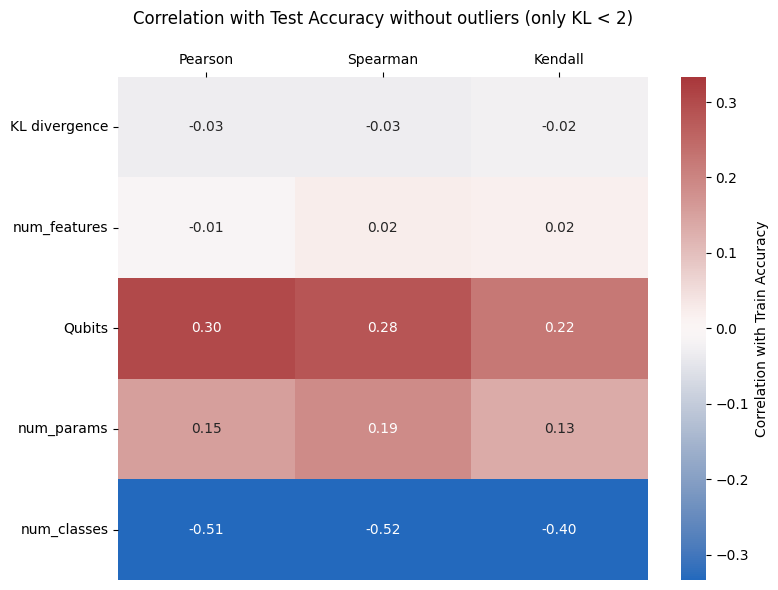

In [18]:
numeric_cols = ['TEST_ACCURACY', 'KL divergence', 'num_features', 'Qubits', 'num_params', 'num_classes']

# Calculate correlation matrix
corr_matrix   =   df_to_plot[numeric_cols].corr(method='pearson')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Pearson'})
corr_matrix = corr_matrix.join( df_to_plot[numeric_cols].corr(method='spearman')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Spearman'}) )
corr_matrix = corr_matrix.join( df_to_plot[numeric_cols].corr(method='kendall')[['TEST_ACCURACY']].rename(columns={'TEST_ACCURACY': 'Kendall'}) )

corr_matrix = corr_matrix.drop('TEST_ACCURACY')

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='vlag', center=0, fmt=".2f", 
            vmin=-1/3, vmax=1/3, cbar_kws={'label': 'Correlation with Train Accuracy'})

plt.title(f"Correlation with Test Accuracy without outliers (only KL < {KLMAX})\n")
# plt.yticks(rotation=0)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()